# Non-destructive Fruit Quality Monitoring using Electronic Nose + ML

## Problem Statement
How can we use low-cost gas sensors (MQ array) and machine learning to classify fruit quality/freshness in real time, enabling safer food, reduced waste, and improved supply-chain decisions?

## Why This Fits the Course
- **Industry 4.0:** sensors + data + automation
- **Agri 5.0:** human-centered decision support
- **IoT-ready:** can run in storage rooms, markets, transport
- **Sustainability:** food loss reduction = big impact

## Output
- Multiple Deep Learning models (1D CNN, 1D CNN+LSTM, 1D CNN+Transformer)
- Training and evaluation pipeline using PyTorch
- Decision rules for quality control

In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, 
    precision_recall_fscore_support
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.1+cu126


## 1. Data Loading and Preprocessing

### Preprocessing Options:
1. **Normalization & Scaling**: 
   - `none`: Raw sensor values
   - `standard`: StandardScaler (mean=0, std=1)
   - `minmax`: MinMaxScaler (range [0,1])
   - `robust`: RobustScaler (median-based, robust to outliers)
   - `per_sensor`: Independent scaling per sensor

2. **Windowing & Segmentation**:
   - Non-overlapping windows (default)
   - Sliding window (stride=1)
   - Custom stride (stride=N)

3. **VOC Drift Handling**:
   - `baseline`: Subtract initial value (removes baseline drift)
   - `relative`: Normalize by baseline (relative change)
   - `moving_baseline`: Use moving average as baseline

In [4]:
class FruitQualityDataset(Dataset):
    """
    PyTorch Dataset for fruit quality monitoring data.
    Loads CSV files and creates sequences from sensor readings.
    Supports multiple preprocessing options:
    - Normalization/scaling (StandardScaler, MinMaxScaler, RobustScaler)
    - Windowing strategies (non-overlapping, sliding window)
    - VOC drift handling (baseline correction, per-sensor normalization)
    """
    def __init__(self, data_dir, sequence_length=100, transform=None, 
                 normalization='none', scaler=None,
                 window_stride=None, handle_drift=False, drift_method='baseline'):
        """
        Args:
            data_dir: Directory containing CSV files (e.g., 'AllSmaples-Report/')
            sequence_length: Length of time sequences to extract
            transform: Optional transform to apply to samples
            normalization: 'none', 'standard', 'minmax', 'robust', 'per_sensor'
            scaler: Pre-fitted scaler (if None and normalization != 'none', will fit on data)
            window_stride: Stride for sliding window (None = non-overlapping, 1 = sliding window)
            handle_drift: Whether to apply drift compensation
            drift_method: 'baseline' (subtract initial value) or 'relative' (normalize by baseline)
        """
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.normalization = normalization
        self.scaler = scaler
        self.window_stride = window_stride if window_stride is not None else sequence_length
        self.handle_drift = handle_drift
        self.drift_method = drift_method
        
        # Freshness mapping: D1 (fresh) to D5 (oldest)
        self.freshness_mapping = {'D1': 0, 'D2': 1, 'D3': 2, 'D4': 3, 'D5': 4}
        self.freshness_labels = {v: k for k, v in self.freshness_mapping.items()}
        
        # Load and preprocess data
        self.sequences, self.labels = self._load_data()
        
        # Apply drift handling if requested
        if self.handle_drift:
            self._apply_drift_compensation()
        
        # Apply normalization if requested
        if self.normalization != 'none':
            self._apply_normalization()
        
        print(f"Loaded {len(self.sequences)} sequences")
        print(f"Sequence shape: {self.sequences[0].shape}")
        print(f"Number of classes: {len(np.unique(self.labels))}")
        print(f"Class distribution: {pd.Series(self.labels).value_counts().sort_index().to_dict()}")
        print(f"Normalization: {self.normalization}")
        print(f"Window stride: {self.window_stride} ({'sliding' if self.window_stride < self.sequence_length else 'non-overlapping'})")
        print(f"Drift handling: {'Enabled (' + self.drift_method + ')' if self.handle_drift else 'Disabled'}")
    
    def _load_data(self):
        """Load data from CSV files and create sequences."""
        all_sequences = []
        all_labels = []
        
        if not os.path.exists(self.data_dir):
            raise ValueError(f"Data directory not found: {self.data_dir}")
        
        print(f"--- Loading data from {self.data_dir} ---")
        
        for filename in os.listdir(self.data_dir):
            if filename.endswith('.csv'):
                filepath = os.path.join(self.data_dir, filename)
                
                # Extract label from filename (e.g., 'Banana D2.csv' -> 'D2')
                parts = filename.replace('.csv', '').split(' ')
                if len(parts) > 1 and parts[-1] in self.freshness_mapping:
                    label_str = parts[-1]
                    label = self.freshness_mapping[label_str]
                    
                    try:
                        df = pd.read_csv(filepath)
                        
                        # Extract sensor columns (MQ2 to MQ135)
                        sensor_columns = [col for col in df.columns if col.startswith('MQ')]
                        if not sensor_columns:
                            print(f"Warning: No MQ sensor columns found in {filename}")
                            continue
                        
                        sensor_data = df[sensor_columns].values
                        
                        # Create sequences with specified windowing strategy
                        if len(sensor_data) >= self.sequence_length:
                            # Extract sequences with specified stride (sliding window or non-overlapping)
                            for i in range(0, len(sensor_data) - self.sequence_length + 1, self.window_stride):
                                sequence = sensor_data[i:i + self.sequence_length]
                                all_sequences.append(sequence)
                                all_labels.append(label)
                        else:
                            # If data is shorter than sequence_length, pad it
                            padded = np.pad(sensor_data, ((0, self.sequence_length - len(sensor_data)), (0, 0)), 
                                          mode='constant', constant_values=0)
                            all_sequences.append(padded)
                            all_labels.append(label)
                    
                    except Exception as e:
                        print(f"Error reading {filename}: {e}")
                        continue
        
        if not all_sequences:
            raise ValueError("No valid data sequences found. Please check the data directory and file names.")
        
        return np.array(all_sequences, dtype=np.float32), np.array(all_labels, dtype=np.int64)
    
    def _apply_drift_compensation(self):
        """
        Apply drift compensation to handle sensor baseline drift over time.
        Common in electronic nose sensors where baseline can shift.
        """
        if self.drift_method == 'baseline':
            # Subtract the initial value (baseline) from each sequence
            # This removes baseline drift while preserving relative changes
            for i in range(len(self.sequences)):
                baseline = self.sequences[i][0, :]  # First time point for each sensor
                self.sequences[i] = self.sequences[i] - baseline
            print("Applied baseline correction (subtract initial value)")
        
        elif self.drift_method == 'relative':
            # Normalize by baseline: (value - baseline) / baseline
            # This gives relative change from baseline
            for i in range(len(self.sequences)):
                baseline = self.sequences[i][0, :]
                # Avoid division by zero
                baseline = np.where(baseline == 0, 1, baseline)
                self.sequences[i] = (self.sequences[i] - baseline) / baseline
            print("Applied relative normalization (normalize by baseline)")
        
        elif self.drift_method == 'moving_baseline':
            # Use moving average as baseline (more robust to initial noise)
            window_size = min(10, self.sequence_length // 10)
            for i in range(len(self.sequences)):
                baseline = np.mean(self.sequences[i][:window_size, :], axis=0)
                self.sequences[i] = self.sequences[i] - baseline
            print(f"Applied moving baseline correction (window={window_size})")
    
    def _apply_normalization(self):
        """Apply normalization/scaling to sequences."""
        original_shape = self.sequences.shape
        # Reshape to (n_samples * sequence_length, n_features) for scaling
        n_samples, seq_len, n_features = original_shape
        sequences_flat = self.sequences.reshape(-1, n_features)
        
        if self.normalization == 'per_sensor':
            # Normalize each sensor independently across all sequences
            # This handles different sensor scales
            if self.scaler is None:
                # Fit per-sensor scalers
                self.scaler = {}
                sequences_scaled = np.zeros_like(sequences_flat)
                for sensor_idx in range(n_features):
                    scaler = StandardScaler()
                    sensor_data = sequences_flat[:, sensor_idx].reshape(-1, 1)
                    sequences_scaled[:, sensor_idx] = scaler.fit_transform(sensor_data).flatten()
                    self.scaler[sensor_idx] = scaler
                print("Per-sensor StandardScaler fitted on data")
            else:
                # Use pre-fitted scalers
                sequences_scaled = np.zeros_like(sequences_flat)
                for sensor_idx in range(n_features):
                    sensor_data = sequences_flat[:, sensor_idx].reshape(-1, 1)
                    sequences_scaled[:, sensor_idx] = self.scaler[sensor_idx].transform(sensor_data).flatten()
        else:
            # Global normalization across all sensors
            if self.scaler is None:
                if self.normalization == 'standard':
                    self.scaler = StandardScaler()
                elif self.normalization == 'minmax':
                    self.scaler = MinMaxScaler()
                elif self.normalization == 'robust':
                    self.scaler = RobustScaler()
                else:
                    raise ValueError(f"Unknown normalization method: {self.normalization}")
                
                sequences_scaled = self.scaler.fit_transform(sequences_flat)
                print(f"{self.normalization.capitalize()}Scaler fitted on data")
            else:
                # Use pre-fitted scaler (for test/validation sets)
                sequences_scaled = self.scaler.transform(sequences_flat)
        
        # Reshape back to original shape
        self.sequences = sequences_scaled.reshape(original_shape).astype(np.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        
        # Convert to torch tensors
        sequence = torch.FloatTensor(sequence)
        label = torch.LongTensor([label])[0]
        
        if self.transform:
            sequence = self.transform(sequence)
        
        return sequence, label

In [5]:
# ============================================================================
# PREPROCESSING CONFIGURATION SYSTEM
# ============================================================================
# Define different preprocessing configurations that can be used during training
# Each configuration can be selected for different experiments

PREPROCESSING_CONFIGURATIONS = {
    'prep_base': {
        'name': 'prep_base',
        'normalization': 'standard',  # Options: 'none', 'standard', 'minmax', 'robust', 'per_sensor'
        'window_stride': None,  # None = non-overlapping, 1 = sliding window, N = stride of N
        'handle_drift': False,  # Set to True to apply drift compensation
        'drift_method': 'baseline'  # Options: 'baseline', 'relative', 'moving_baseline'
    },
    'prep_no_norm': {
        'name': 'prep_no_norm',
        'normalization': 'none',
        'window_stride': None,
        'handle_drift': False,
        'drift_method': None
    },
    'prep_with_drift': {
        'name': 'prep_with_drift',
        'normalization': 'standard',
        'window_stride': None,
        'handle_drift': True,
        'drift_method': 'baseline'
    },
    'prep_sliding_window': {
        'name': 'prep_sliding_window',
        'normalization': 'standard',
        'window_stride': 1,  # Sliding window
        'handle_drift': False,
        'drift_method': None
    },
    'prep_minmax': {
        'name': 'prep_minmax',
        'normalization': 'minmax',
        'window_stride': None,
        'handle_drift': False,
        'drift_method': None
    },
    'prep_robust': {
        'name': 'prep_robust',
        'normalization': 'robust',
        'window_stride': None,
        'handle_drift': False,
        'drift_method': None
    }
}

# Select which preprocessing configuration to use
# Change this to experiment with different preprocessing options
SELECTED_PREPROCESSING = 'prep_base'  # Options: 'prep_base', 'prep_no_norm', 'prep_with_drift', etc.

# Extract preprocessing parameters from selected configuration
prep_config = PREPROCESSING_CONFIGURATIONS[SELECTED_PREPROCESSING]
NORMALIZATION = prep_config['normalization']
WINDOW_STRIDE = prep_config['window_stride']
HANDLE_DRIFT = prep_config['handle_drift']
DRIFT_METHOD = prep_config.get('drift_method', 'baseline') if HANDLE_DRIFT else None

# Other configuration parameters
DATA_DIR = './AllSmaples-Report'  # Update this path if needed
SEQUENCE_LENGTH = 100  # Length of time sequences
BATCH_SIZE = 32
TEST_SIZE = 0.25  # 25% hold-out test set (not used during training)
VAL_SIZE = 0.2  # 20% of training data for validation (20% of 75% = 15% of total)
RANDOM_STATE = 42

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"\nSelected Preprocessing Configuration: {SELECTED_PREPROCESSING}")
print(f"  Normalization: {NORMALIZATION}")
print(f"  Window Strategy: {'Sliding window' if WINDOW_STRIDE == 1 else 'Non-overlapping' if WINDOW_STRIDE is None else f'Stride={WINDOW_STRIDE}'}")
print(f"  Drift Handling: {'Enabled (' + DRIFT_METHOD + ')' if HANDLE_DRIFT else 'Disabled'}")
print(f"\nOther Parameters:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Hold-out Test Size: {TEST_SIZE*100:.0f}% (not used during training)")
print(f"  Validation Size: {VAL_SIZE*100:.0f}% of training data")
print("\n💡 Available Preprocessing Configurations:")
for prep_name, prep_cfg in PREPROCESSING_CONFIGURATIONS.items():
    marker = " ← SELECTED" if prep_name == SELECTED_PREPROCESSING else ""
    print(f"  - {prep_name}: norm={prep_cfg['normalization']}, drift={prep_cfg['handle_drift']}, window={prep_cfg['window_stride']}{marker}")
print("="*60)

# Load full dataset once
full_dataset = FruitQualityDataset(
    DATA_DIR, 
    sequence_length=SEQUENCE_LENGTH, 
    normalization='none',  # Load raw data first
    window_stride=WINDOW_STRIDE,
    handle_drift=False  # Will apply after split
)

# Step 1: Split into train (75%) and hold-out test (25%)
train_indices, test_indices = train_test_split(
    range(len(full_dataset)), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=full_dataset.labels
)

# Step 2: Split train set into training and validation
# VAL_SIZE is relative to the training set (e.g., 0.2 means 20% of 75% = 15% of total)
train_labels_subset = full_dataset.labels[train_indices]
train_train_indices, train_val_indices = train_test_split(
    train_indices,
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=train_labels_subset
)

print(f"\nData Split:")
print(f"  Training set: {len(train_train_indices)} samples ({len(train_train_indices)/len(full_dataset)*100:.1f}%)")
print(f"  Validation set: {len(train_val_indices)} samples ({len(train_val_indices)/len(full_dataset)*100:.1f}%)")
print(f"  Hold-out test set: {len(test_indices)} samples ({len(test_indices)/len(full_dataset)*100:.1f}%)")

# Extract sequences for scaler fitting (use only training data, not validation)
# Make copies to avoid modifying the original dataset
train_sequences_raw = full_dataset.sequences[train_train_indices].copy()
val_sequences_raw = full_dataset.sequences[train_val_indices].copy()
test_sequences_raw = full_dataset.sequences[test_indices].copy()

# Apply drift compensation if requested
if HANDLE_DRIFT:
    # Apply drift compensation to training data
    for i in range(len(train_sequences_raw)):
        if DRIFT_METHOD == 'baseline':
            baseline = train_sequences_raw[i][0, :]
            train_sequences_raw[i] = train_sequences_raw[i] - baseline
        elif DRIFT_METHOD == 'relative':
            baseline = train_sequences_raw[i][0, :]
            baseline = np.where(baseline == 0, 1, baseline)
            train_sequences_raw[i] = (train_sequences_raw[i] - baseline) / baseline
        elif DRIFT_METHOD == 'moving_baseline':
            window_size = min(10, SEQUENCE_LENGTH // 10)
            baseline = np.mean(train_sequences_raw[i][:window_size, :], axis=0)
            train_sequences_raw[i] = train_sequences_raw[i] - baseline
    
    # Apply same drift compensation to validation data
    for i in range(len(val_sequences_raw)):
        if DRIFT_METHOD == 'baseline':
            baseline = val_sequences_raw[i][0, :]
            val_sequences_raw[i] = val_sequences_raw[i] - baseline
        elif DRIFT_METHOD == 'relative':
            baseline = val_sequences_raw[i][0, :]
            baseline = np.where(baseline == 0, 1, baseline)
            val_sequences_raw[i] = (val_sequences_raw[i] - baseline) / baseline
        elif DRIFT_METHOD == 'moving_baseline':
            window_size = min(10, SEQUENCE_LENGTH // 10)
            baseline = np.mean(val_sequences_raw[i][:window_size, :], axis=0)
            val_sequences_raw[i] = val_sequences_raw[i] - baseline
    
    # Apply same drift compensation to hold-out test data
    for i in range(len(test_sequences_raw)):
        if DRIFT_METHOD == 'baseline':
            baseline = test_sequences_raw[i][0, :]
            test_sequences_raw[i] = test_sequences_raw[i] - baseline
        elif DRIFT_METHOD == 'relative':
            baseline = test_sequences_raw[i][0, :]
            baseline = np.where(baseline == 0, 1, baseline)
            test_sequences_raw[i] = (test_sequences_raw[i] - baseline) / baseline
        elif DRIFT_METHOD == 'moving_baseline':
            window_size = min(10, SEQUENCE_LENGTH // 10)
            baseline = np.mean(test_sequences_raw[i][:window_size, :], axis=0)
            test_sequences_raw[i] = test_sequences_raw[i] - baseline
    
    print(f"Applied drift compensation ({DRIFT_METHOD})")

# Fit scaler on training data only
scaler = None
if NORMALIZATION != 'none':
    n_samples, seq_len, n_features = train_sequences_raw.shape
    train_flat = train_sequences_raw.reshape(-1, n_features)
    
    if NORMALIZATION == 'per_sensor':
        # Fit per-sensor scalers
        scaler = {}
        for sensor_idx in range(n_features):
            s = StandardScaler()
            s.fit(train_flat[:, sensor_idx].reshape(-1, 1))
            scaler[sensor_idx] = s
    else:
        # Fit global scaler
        if NORMALIZATION == 'standard':
            scaler = StandardScaler()
        elif NORMALIZATION == 'minmax':
            scaler = MinMaxScaler()
        elif NORMALIZATION == 'robust':
            scaler = RobustScaler()
        scaler.fit(train_flat)
    
    print(f"{NORMALIZATION.capitalize()}Scaler fitted on training data")
    
    # Apply normalization to train, validation, and test
    train_flat = train_sequences_raw.reshape(-1, n_features)
    val_flat = val_sequences_raw.reshape(-1, n_features)
    test_flat = test_sequences_raw.reshape(-1, n_features)
    
    if NORMALIZATION == 'per_sensor':
        train_scaled = np.zeros_like(train_flat)
        val_scaled = np.zeros_like(val_flat)
        test_scaled = np.zeros_like(test_flat)
        for sensor_idx in range(n_features):
            train_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                train_flat[:, sensor_idx].reshape(-1, 1)
            ).flatten()
            val_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                val_flat[:, sensor_idx].reshape(-1, 1)
            ).flatten()
            test_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                test_flat[:, sensor_idx].reshape(-1, 1)
            ).flatten()
        train_sequences = train_scaled.reshape(train_sequences_raw.shape).astype(np.float32)
        val_sequences = val_scaled.reshape(val_sequences_raw.shape).astype(np.float32)
        test_sequences = test_scaled.reshape(test_sequences_raw.shape).astype(np.float32)
    else:
        train_scaled = scaler.transform(train_flat)
        val_scaled = scaler.transform(val_flat)
        test_scaled = scaler.transform(test_flat)
        train_sequences = train_scaled.reshape(train_sequences_raw.shape).astype(np.float32)
        val_sequences = val_scaled.reshape(val_sequences_raw.shape).astype(np.float32)
        test_sequences = test_scaled.reshape(test_sequences_raw.shape).astype(np.float32)
else:
    train_sequences = train_sequences_raw.astype(np.float32)
    val_sequences = val_sequences_raw.astype(np.float32)
    test_sequences = test_sequences_raw.astype(np.float32)

# Create final datasets with processed sequences
# IMPORTANT: Use the preprocessed sequences, not the raw full_dataset
train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(train_sequences),
    torch.LongTensor(full_dataset.labels[train_train_indices])
)
val_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(val_sequences),
    torch.LongTensor(full_dataset.labels[train_val_indices])
)
test_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(test_sequences),
    torch.LongTensor(full_dataset.labels[test_indices])
)

# Verify data preprocessing consistency
print(f"\nData Preprocessing Verification:")
print(f"  Train sequences shape: {train_sequences.shape}")
print(f"  Train sequences mean: {train_sequences.mean():.4f}, std: {train_sequences.std():.4f}")
print(f"  Val sequences shape: {val_sequences.shape}")
print(f"  Val sequences mean: {val_sequences.mean():.4f}, std: {val_sequences.std():.4f}")
print(f"  Test sequences shape: {test_sequences.shape}")
print(f"  Test sequences mean: {test_sequences.mean():.4f}, std: {test_sequences.std():.4f}")
print(f"  Train labels distribution: {np.bincount(full_dataset.labels[train_train_indices])}")
print(f"  Val labels distribution: {np.bincount(full_dataset.labels[train_val_indices])}")
print(f"  Test labels distribution: {np.bincount(full_dataset.labels[test_indices])}")

# Get dataset info
num_features = train_sequences.shape[2]  # Number of sensors
num_classes = len(np.unique(full_dataset.labels))
class_names = [full_dataset.freshness_labels[i] for i in range(num_classes)]

print(f"\nDataset Info:")
print(f"  Number of features (sensors): {num_features}")
print(f"  Number of classes: {num_classes}")
print(f"  Sequence length: {SEQUENCE_LENGTH}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nData Loaders Created:")
print(f"  Training samples: {len(train_dataset)} (used for training)")
print(f"  Validation samples: {len(val_dataset)} (used for validation during training)")
print(f"  Hold-out test samples: {len(test_dataset)} (reserved for final evaluation)")
print(f"  Batch size: {BATCH_SIZE}")

CONFIGURATION

Selected Preprocessing Configuration: prep_base
  Normalization: standard
  Window Strategy: Non-overlapping
  Drift Handling: Disabled

Other Parameters:
  Sequence Length: 100
  Batch Size: 32
  Hold-out Test Size: 25% (not used during training)
  Validation Size: 20% of training data

💡 Available Preprocessing Configurations:
  - prep_base: norm=standard, drift=False, window=None ← SELECTED
  - prep_no_norm: norm=none, drift=False, window=None
  - prep_with_drift: norm=standard, drift=True, window=None
  - prep_sliding_window: norm=standard, drift=False, window=1
  - prep_minmax: norm=minmax, drift=False, window=None
  - prep_robust: norm=robust, drift=False, window=None
--- Loading data from ./AllSmaples-Report ---
Loaded 6540 sequences
Sequence shape: (100, 9)
Number of classes: 5
Class distribution: {0: 1520, 1: 1327, 2: 1284, 3: 1247, 4: 1162}
Normalization: none
Window stride: 100 (non-overlapping)
Drift handling: Disabled

Data Split:
  Training set: 3924 sample

## 2. Model Architectures

We'll implement three deep learning models:
1. **1D CNN**: Convolutional layers for feature extraction
2. **1D CNN + LSTM**: CNN for features, LSTM for temporal dependencies
3. **1D CNN + Transformer**: CNN for features, Transformer for attention-based sequence modeling

In [6]:
def get_activation(activation_name='relu'):
    """Get activation function by name"""
    activations = {
        'relu': nn.ReLU(),
        'gelu': nn.GELU(),
        'elu': nn.ELU(),
        'leaky_relu': nn.LeakyReLU(0.2),
        'tanh': nn.Tanh(),
        'swish': nn.SiLU(),  # SiLU is Swish
        'mish': nn.Mish() if hasattr(nn, 'Mish') else nn.ReLU()
    }
    return activations.get(activation_name.lower(), nn.ReLU())


def get_activation(activation_name='relu'):
    """
    Get activation function by name.
    
    Args:
        activation_name: Name of activation function
            Options: 'relu', 'gelu', 'elu', 'leaky_relu', 'tanh', 'swish', 'mish'
    
    Returns:
        PyTorch activation function module
    """
    activations = {
        'relu': nn.ReLU(),
        'gelu': nn.GELU(),
        'elu': nn.ELU(),
        'leaky_relu': nn.LeakyReLU(0.2),
        'tanh': nn.Tanh(),
        'swish': nn.SiLU(),  # SiLU is Swish
        'mish': nn.Mish() if hasattr(nn, 'Mish') else nn.ReLU()
    }
    return activations.get(activation_name.lower(), nn.ReLU())


class CNN1D(nn.Module):
    """
    1D Convolutional Neural Network for time-series classification.
    Uses multiple convolutional layers to extract features from sensor sequences.
    
    Configurable hyperparameters:
    - Activation functions
    - Kernel sizes
    - Number of filters
    - Dropout rates
    - Fully connected layer sizes
    """
    def __init__(self, input_channels, num_classes, sequence_length,
                 filters=[64, 128, 256], kernel_sizes=[5, 5, 3],
                 fc_sizes=[128, 64], dropout_conv=0.3, dropout_fc=0.5,
                 activation='relu', use_batch_norm=True, pool_size=2):
        """
        Args:
            input_channels: Number of input features (sensors)
            num_classes: Number of output classes
            sequence_length: Length of input sequences
            filters: List of filter sizes for each conv layer [default: [64, 128, 256]]
            kernel_sizes: List of kernel sizes for each conv layer [default: [5, 5, 3]]
            fc_sizes: List of sizes for fully connected layers [default: [128, 64]]
            dropout_conv: Dropout rate after conv layers [default: 0.3]
            dropout_fc: Dropout rate after FC layers [default: 0.5]
            activation: Activation function name ('relu', 'gelu', 'elu', 'leaky_relu', 'tanh', 'swish', 'mish')
            use_batch_norm: Whether to use batch normalization [default: True]
            pool_size: Pooling size [default: 2]
        """
        super(CNN1D, self).__init__()
        
        self.activation_fn = get_activation(activation)
        self.use_batch_norm = use_batch_norm
        
        # Ensure we have enough filters and kernel sizes
        num_conv_layers = max(len(filters), len(kernel_sizes))
        if len(filters) < num_conv_layers:
            filters = filters + [filters[-1]] * (num_conv_layers - len(filters))
        if len(kernel_sizes) < num_conv_layers:
            kernel_sizes = kernel_sizes + [kernel_sizes[-1]] * (num_conv_layers - len(kernel_sizes))
        
        # Build convolutional blocks dynamically
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        in_channels = input_channels
        current_length = sequence_length
        
        for i, (out_channels, kernel_size) in enumerate(zip(filters, kernel_sizes)):
            padding = kernel_size // 2  # Same padding
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding))
            if self.use_batch_norm:
                self.bn_layers.append(nn.BatchNorm1d(out_channels))
            self.pool_layers.append(nn.MaxPool1d(pool_size))
            self.dropout_layers.append(nn.Dropout(dropout_conv))
            in_channels = out_channels
            current_length = current_length // pool_size
        
        # Calculate flattened size after convolutions
        self.flattened_size = filters[-1] * current_length
        
        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_dropouts = nn.ModuleList()
        
        fc_input_size = self.flattened_size
        for fc_size in fc_sizes:
            self.fc_layers.append(nn.Linear(fc_input_size, fc_size))
            self.fc_dropouts.append(nn.Dropout(dropout_fc))
            fc_input_size = fc_size
        
        # Output layer
        self.fc_out = nn.Linear(fc_input_size, num_classes)
        
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, num_features)
        # Transpose to: (batch_size, num_features, sequence_length) for Conv1d
        x = x.transpose(1, 2)
        
        # Convolutional blocks
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            if self.use_batch_norm:
                x = self.bn_layers[i](x)
            x = self.activation_fn(x)
            x = self.pool_layers[i](x)
            x = self.dropout_layers[i](x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        for fc_layer, dropout in zip(self.fc_layers, self.fc_dropouts):
            x = self.activation_fn(fc_layer(x))
            x = dropout(x)
        
        # Output layer
        x = self.fc_out(x)
        
        return x

In [7]:
class CNN_LSTM(nn.Module):
    """
    Hybrid model combining 1D CNN for feature extraction and LSTM for sequence modeling.
    CNN extracts local patterns, LSTM captures long-term dependencies.
    
    Configurable hyperparameters:
    - CNN filters, kernel sizes, activation
    - LSTM hidden size, number of layers, bidirectional
    - Dropout rates
    - Fully connected layer sizes
    """
    def __init__(self, input_channels, num_classes, sequence_length,
                 cnn_filters=[64, 128], cnn_kernel_sizes=[5, 5],
                 lstm_hidden=128, lstm_layers=2, lstm_bidirectional=True,
                 fc_sizes=[128, 64], dropout_conv=0.3, dropout_lstm=0.3, dropout_fc=0.5,
                 activation='relu', use_batch_norm=True, pool_size=2):
        """
        Args:
            input_channels: Number of input features (sensors)
            num_classes: Number of output classes
            sequence_length: Length of input sequences
            cnn_filters: List of CNN filter sizes [default: [64, 128]]
            cnn_kernel_sizes: List of CNN kernel sizes [default: [5, 5]]
            lstm_hidden: LSTM hidden size [default: 128]
            lstm_layers: Number of LSTM layers [default: 2]
            lstm_bidirectional: Whether LSTM is bidirectional [default: True]
            fc_sizes: List of FC layer sizes [default: [128, 64]]
            dropout_conv: Dropout after conv layers [default: 0.3]
            dropout_lstm: Dropout in LSTM [default: 0.3]
            dropout_fc: Dropout after FC layers [default: 0.5]
            activation: Activation function name [default: 'relu']
            use_batch_norm: Use batch normalization [default: True]
            pool_size: Pooling size [default: 2]
        """
        super(CNN_LSTM, self).__init__()
        
        self.activation_fn = get_activation(activation)
        self.use_batch_norm = use_batch_norm
        
        # Ensure we have matching filters and kernel sizes
        num_cnn_layers = max(len(cnn_filters), len(cnn_kernel_sizes))
        if len(cnn_filters) < num_cnn_layers:
            cnn_filters = cnn_filters + [cnn_filters[-1]] * (num_cnn_layers - len(cnn_filters))
        if len(cnn_kernel_sizes) < num_cnn_layers:
            cnn_kernel_sizes = cnn_kernel_sizes + [cnn_kernel_sizes[-1]] * (num_cnn_layers - len(cnn_kernel_sizes))
        
        # Build CNN layers
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        in_channels = input_channels
        current_length = sequence_length
        
        for out_channels, kernel_size in zip(cnn_filters, cnn_kernel_sizes):
            padding = kernel_size // 2
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding))
            if self.use_batch_norm:
                self.bn_layers.append(nn.BatchNorm1d(out_channels))
            self.pool_layers.append(nn.MaxPool1d(pool_size))
            self.dropout_layers.append(nn.Dropout(dropout_conv))
            in_channels = out_channels
            current_length = current_length // pool_size
        
        self.cnn_output_length = current_length
        self.cnn_output_channels = cnn_filters[-1]
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_channels,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout_lstm if lstm_layers > 1 else 0,
            bidirectional=lstm_bidirectional
        )
        
        # LSTM output size
        lstm_output_size = (2 if lstm_bidirectional else 1) * lstm_hidden
        
        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_dropouts = nn.ModuleList()
        
        fc_input_size = lstm_output_size
        for fc_size in fc_sizes:
            self.fc_layers.append(nn.Linear(fc_input_size, fc_size))
            self.fc_dropouts.append(nn.Dropout(dropout_fc))
            fc_input_size = fc_size
        
        # Output layer
        self.fc_out = nn.Linear(fc_input_size, num_classes)
        
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, num_features)
        # Transpose for Conv1d: (batch_size, num_features, sequence_length)
        x = x.transpose(1, 2)
        
        # CNN feature extraction
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            if self.use_batch_norm:
                x = self.bn_layers[i](x)
            x = self.activation_fn(x)
            x = self.pool_layers[i](x)
            x = self.dropout_layers[i](x)
        
        # Transpose back for LSTM: (batch_size, sequence_length/4, channels)
        x = x.transpose(1, 2)
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last output from LSTM
        x = lstm_out[:, -1, :]
        
        # Fully connected layers
        for fc_layer, dropout in zip(self.fc_layers, self.fc_dropouts):
            x = self.activation_fn(fc_layer(x))
            x = dropout(x)
        
        # Output layer
        x = self.fc_out(x)
        
        return x

In [8]:
class CNN_Transformer(nn.Module):
    """
    Hybrid model combining 1D CNN for feature extraction and Transformer for attention-based sequence modeling.
    CNN extracts local features, Transformer captures global dependencies with self-attention.
    
    Configurable hyperparameters:
    - CNN filters, kernel sizes, activation
    - Transformer dimensions (d_model, nhead, num_layers, dim_feedforward)
    - Dropout rates
    - Fully connected layer sizes
    """
    def __init__(self, input_channels, num_classes, sequence_length,
                 cnn_filters=[64, 128], cnn_kernel_sizes=[5, 5],
                 d_model=128, nhead=8, num_layers=2, dim_feedforward=512,
                 fc_sizes=[128, 64], dropout_conv=0.3, dropout_transformer=0.1, dropout_fc=0.5,
                 activation='relu', use_batch_norm=True, pool_size=2):
        """
        Args:
            input_channels: Number of input features (sensors)
            num_classes: Number of output classes
            sequence_length: Length of input sequences
            cnn_filters: List of CNN filter sizes [default: [64, 128]]
            cnn_kernel_sizes: List of CNN kernel sizes [default: [5, 5]]
            d_model: Transformer model dimension [default: 128]
            nhead: Number of attention heads [default: 8]
            num_layers: Number of transformer layers [default: 2]
            dim_feedforward: Feedforward dimension [default: 512]
            fc_sizes: List of FC layer sizes [default: [128, 64]]
            dropout_conv: Dropout after conv layers [default: 0.3]
            dropout_transformer: Dropout in transformer [default: 0.1]
            dropout_fc: Dropout after FC layers [default: 0.5]
            activation: Activation function name [default: 'relu']
            use_batch_norm: Use batch normalization [default: True]
            pool_size: Pooling size [default: 2]
        """
        super(CNN_Transformer, self).__init__()
        
        self.activation_fn = get_activation(activation)
        self.use_batch_norm = use_batch_norm
        
        # Ensure we have matching filters and kernel sizes
        num_cnn_layers = max(len(cnn_filters), len(cnn_kernel_sizes))
        if len(cnn_filters) < num_cnn_layers:
            cnn_filters = cnn_filters + [cnn_filters[-1]] * (num_cnn_layers - len(cnn_filters))
        if len(cnn_kernel_sizes) < num_cnn_layers:
            cnn_kernel_sizes = cnn_kernel_sizes + [cnn_kernel_sizes[-1]] * (num_cnn_layers - len(cnn_kernel_sizes))
        
        # Build CNN layers
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        in_channels = input_channels
        current_length = sequence_length
        
        for i, (out_channels, kernel_size) in enumerate(zip(cnn_filters, cnn_kernel_sizes)):
            padding = kernel_size // 2
            # Last layer should output d_model
            if i == len(cnn_filters) - 1:
                out_channels = d_model
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding))
            if self.use_batch_norm:
                self.bn_layers.append(nn.BatchNorm1d(out_channels))
            self.pool_layers.append(nn.MaxPool1d(pool_size))
            self.dropout_layers.append(nn.Dropout(dropout_conv))
            in_channels = out_channels
            current_length = current_length // pool_size
        
        self.cnn_output_length = current_length
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout_transformer, max_len=self.cnn_output_length)
        
        # Transformer encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout_transformer,
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_dropouts = nn.ModuleList()
        
        fc_input_size = d_model
        for fc_size in fc_sizes:
            self.fc_layers.append(nn.Linear(fc_input_size, fc_size))
            self.fc_dropouts.append(nn.Dropout(dropout_fc))
            fc_input_size = fc_size
        
        # Output layer
        self.fc_out = nn.Linear(fc_input_size, num_classes)
        
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, num_features)
        # Transpose for Conv1d: (batch_size, num_features, sequence_length)
        x = x.transpose(1, 2)
        
        # CNN feature extraction
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            if self.use_batch_norm:
                x = self.bn_layers[i](x)
            x = self.activation_fn(x)
            x = self.pool_layers[i](x)
            x = self.dropout_layers[i](x)
        
        # Transpose back for Transformer: (batch_size, sequence_length/4, d_model)
        x = x.transpose(1, 2)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoder
        x = self.transformer_encoder(x)
        
        # Global average pooling over sequence dimension
        x = x.mean(dim=1)
        
        # Fully connected layers
        for fc_layer, dropout in zip(self.fc_layers, self.fc_dropouts):
            x = self.activation_fn(fc_layer(x))
            x = dropout(x)
        
        # Output layer
        x = self.fc_out(x)
        
        return x


class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## 3. Training and Evaluation Functions

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, val_loader, criterion, device):
    """Evaluate the model on validation data."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    # Convert accuracy to percentage to match train_epoch format (0-100 instead of 0-1)
    accuracy = accuracy_score(all_labels, all_preds) * 100
    
    return epoch_loss, accuracy, all_preds, all_labels


def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, 
                patience=10, model_name="model"):
    """
    Complete training pipeline with early stopping using validation set.
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data (used during training)
        num_epochs: Maximum number of epochs
        learning_rate: Learning rate for optimizer
        patience: Early stopping patience
        model_name: Name for saving the model
    
    Returns:
        model: Trained model
        history: Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate on validation set
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Learning rate scheduling based on validation loss
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Early stopping based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                print(f"Best validation accuracy: {best_val_acc:.2f}%")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%")
    
    return model, history

In [10]:
def plot_training_history(history, model_name):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axes[0].plot(history['val_acc'], label='Validation Accuracy', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[1].plot(history['val_loss'], label='Validation Loss', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def compute_comprehensive_metrics(y_true, y_pred, class_names):
    """
    Compute comprehensive metrics including per-class and aggregate metrics.
    
    Returns:
        Dictionary with all metrics
    """
    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Aggregate metrics
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Support (number of samples per class)
    support = np.bincount(y_true, minlength=len(class_names))
    
    metrics = {
        'accuracy': accuracy,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'support': support
    }
    
    return metrics


def print_classification_report(y_true, y_pred, class_names, model_name):
    """Print detailed classification report with comprehensive metrics."""
    print(f"\n{'='*60}")
    print(f"{model_name} - Classification Report")
    print(f"{'='*60}")
    
    # Print sklearn classification report
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Compute and print additional metrics
    metrics = compute_comprehensive_metrics(y_true, y_pred, class_names)
    
    print(f"\n{'='*60}")
    print("Summary Metrics:")
    print(f"{'='*60}")
    print(f"Accuracy:           {metrics['accuracy']:.4f}")
    print(f"Precision (macro):  {metrics['precision_macro']:.4f}")
    print(f"Recall (macro):     {metrics['recall_macro']:.4f}")
    print(f"F1-Score (macro):  {metrics['f1_macro']:.4f}")
    print(f"Precision (weighted): {metrics['precision_weighted']:.4f}")
    print(f"Recall (weighted):    {metrics['recall_weighted']:.4f}")
    print(f"F1-Score (weighted): {metrics['f1_weighted']:.4f}")
    
    # Per-class metrics table
    print(f"\n{'='*60}")
    print("Per-Class Metrics:")
    print(f"{'='*60}")
    print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 60)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<10} {metrics['precision_per_class'][i]:<12.4f} "
              f"{metrics['recall_per_class'][i]:<12.4f} "
              f"{metrics['f1_per_class'][i]:<12.4f} "
              f"{int(metrics['support'][i]):<10}")
    
    return metrics

## 4. Hyperparameter Configuration

Configure hyperparameters for each model architecture. Experiment with different settings to optimize performance.

In [11]:
# ============================================================================
# MULTIPLE CONFIGURATION TRAINING SYSTEM
# ============================================================================
# Define multiple configurations to train and compare
# Each configuration includes: model type, hyperparameters, and preprocessing

# Configuration naming format: {model_type}_{config_id}
# Example: cnn1d_base, cnn1d_deep, cnn_lstm_wide, etc.

MODEL_CONFIGURATIONS = [
    {
        'name': 'cnn1d_base',
        'model_type': 'CNN1D',
        'hyperparameters': {
            'filters': [64, 128, 256],
            'kernel_sizes': [5, 5, 3],
            'fc_sizes': [128, 64],
            'dropout_conv': 0.3,
            'dropout_fc': 0.5,
            'activation': 'relu',
            'use_batch_norm': True,
            'pool_size': 2
        }
    },
    {
        'name': 'cnn1d_deep',
        'model_type': 'CNN1D',
        'hyperparameters': {
            'filters': [32, 64, 128, 256],
            'kernel_sizes': [7, 5, 5, 3],
            'fc_sizes': [256, 128, 64],
            'dropout_conv': 0.4,
            'dropout_fc': 0.6,
            'activation': 'gelu',
            'use_batch_norm': True,
            'pool_size': 2
        }
    },
    {
        'name': 'cnn1d_wide',
        'model_type': 'CNN1D',
        'hyperparameters': {
            'filters': [128, 256, 512],
            'kernel_sizes': [3, 3, 3],
            'fc_sizes': [256, 128],
            'dropout_conv': 0.2,
            'dropout_fc': 0.4,
            'activation': 'swish',
            'use_batch_norm': True,
            'pool_size': 2
        }
    },
    {
        'name': 'cnn_lstm_base',
        'model_type': 'CNN_LSTM',
        'hyperparameters': {
            'cnn_filters': [64, 128],
            'cnn_kernel_sizes': [5, 5],
            'lstm_hidden': 128,
            'lstm_layers': 2,
            'lstm_bidirectional': True,
            'fc_sizes': [128, 64],
            'dropout_conv': 0.3,
            'dropout_lstm': 0.3,
            'dropout_fc': 0.5,
            'activation': 'relu',
            'use_batch_norm': True,
            'pool_size': 2
        }
    },
    {
        'name': 'cnn_lstm_large',
        'model_type': 'CNN_LSTM',
        'hyperparameters': {
            'cnn_filters': [64, 128, 256],
            'cnn_kernel_sizes': [5, 5, 3],
            'lstm_hidden': 256,
            'lstm_layers': 3,
            'lstm_bidirectional': True,
            'fc_sizes': [256, 128],
            'dropout_conv': 0.3,
            'dropout_lstm': 0.4,
            'dropout_fc': 0.5,
            'activation': 'gelu',
            'use_batch_norm': True,
            'pool_size': 2
        }
    },
    {
        'name': 'cnn_transformer_base',
        'model_type': 'CNN_Transformer',
        'hyperparameters': {
            'cnn_filters': [64, 128],
            'cnn_kernel_sizes': [5, 5],
            'd_model': 128,
            'nhead': 8,
            'num_layers': 2,
            'dim_feedforward': 512,
            'fc_sizes': [128, 64],
            'dropout_conv': 0.3,
            'dropout_transformer': 0.1,
            'dropout_fc': 0.5,
            'activation': 'relu',
            'use_batch_norm': True,
            'pool_size': 2
        }
    },
    {
        'name': 'cnn_transformer_large',
        'model_type': 'CNN_Transformer',
        'hyperparameters': {
            'cnn_filters': [64, 128],
            'cnn_kernel_sizes': [5, 5],
            'd_model': 256,
            'nhead': 16,
            'num_layers': 4,
            'dim_feedforward': 1024,
            'fc_sizes': [256, 128],
            'dropout_conv': 0.3,
            'dropout_transformer': 0.2,
            'dropout_fc': 0.5,
            'activation': 'gelu',
            'use_batch_norm': True,
            'pool_size': 2
        }
    }
]

print("="*60)
print("MULTIPLE CONFIGURATION TRAINING")
print("="*60)
print(f"\nDefined {len(MODEL_CONFIGURATIONS)} model configurations:")
for i, config in enumerate(MODEL_CONFIGURATIONS, 1):
    print(f"\n{i}. {config['name']}")
    print(f"   Model Type: {config['model_type']}")
    print(f"   Key Hyperparameters:")
    key_params = ['activation', 'dropout_conv', 'dropout_fc'] if config['model_type'] == 'CNN1D' else \
                 ['activation', 'lstm_hidden', 'lstm_layers'] if config['model_type'] == 'CNN_LSTM' else \
                 ['activation', 'd_model', 'nhead', 'num_layers']
    for key in key_params:
        if key in config['hyperparameters']:
            print(f"      {key}: {config['hyperparameters'][key]}")
print("\n" + "="*60)
print("💡 All configurations will be trained and saved for comparison in Streamlit")
print("="*60)

MULTIPLE CONFIGURATION TRAINING

Defined 7 model configurations:

1. cnn1d_base
   Model Type: CNN1D
   Key Hyperparameters:
      activation: relu
      dropout_conv: 0.3
      dropout_fc: 0.5

2. cnn1d_deep
   Model Type: CNN1D
   Key Hyperparameters:
      activation: gelu
      dropout_conv: 0.4
      dropout_fc: 0.6

3. cnn1d_wide
   Model Type: CNN1D
   Key Hyperparameters:
      activation: swish
      dropout_conv: 0.2
      dropout_fc: 0.4

4. cnn_lstm_base
   Model Type: CNN_LSTM
   Key Hyperparameters:
      activation: relu
      lstm_hidden: 128
      lstm_layers: 2

5. cnn_lstm_large
   Model Type: CNN_LSTM
   Key Hyperparameters:
      activation: gelu
      lstm_hidden: 256
      lstm_layers: 3

6. cnn_transformer_base
   Model Type: CNN_Transformer
   Key Hyperparameters:
      activation: relu
      d_model: 128
      nhead: 8
      num_layers: 2

7. cnn_transformer_large
   Model Type: CNN_Transformer
   Key Hyperparameters:
      activation: gelu
      d_model: 256


In [12]:
# ============================================================================
# HYPERPARAMETER CONFIGURATION
# ============================================================================
# Experiment with these hyperparameters to optimize model performance

# Training hyperparameters
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10

# ============================================================================
# Model 1: 1D CNN Hyperparameters
# ============================================================================
CNN1D_CONFIG = {
    'filters': [64, 128, 256],           # Number of filters per conv layer
    'kernel_sizes': [5, 5, 3],          # Kernel sizes per conv layer
    'fc_sizes': [128, 64],               # Fully connected layer sizes
    'dropout_conv': 0.3,                 # Dropout after conv layers
    'dropout_fc': 0.5,                   # Dropout after FC layers
    'activation': 'relu',                # Options: 'relu', 'gelu', 'elu', 'leaky_relu', 'tanh', 'swish', 'mish'
    'use_batch_norm': True,              # Use batch normalization
    'pool_size': 2                       # Pooling size
}

# ============================================================================
# Model 2: CNN + LSTM Hyperparameters
# ============================================================================
CNN_LSTM_CONFIG = {
    'cnn_filters': [64, 128],            # CNN filter sizes
    'cnn_kernel_sizes': [5, 5],         # CNN kernel sizes
    'lstm_hidden': 128,                  # LSTM hidden size
    'lstm_layers': 2,                    # Number of LSTM layers
    'lstm_bidirectional': True,          # Bidirectional LSTM
    'fc_sizes': [128, 64],               # Fully connected layer sizes
    'dropout_conv': 0.3,                 # Dropout after conv layers
    'dropout_lstm': 0.3,                 # Dropout in LSTM
    'dropout_fc': 0.5,                   # Dropout after FC layers
    'activation': 'relu',                # Activation function
    'use_batch_norm': True,              # Use batch normalization
    'pool_size': 2                       # Pooling size
}

# ============================================================================
# Model 3: CNN + Transformer Hyperparameters
# ============================================================================
CNN_TRANSFORMER_CONFIG = {
    'cnn_filters': [64, 128],            # CNN filter sizes (last will be set to d_model)
    'cnn_kernel_sizes': [5, 5],         # CNN kernel sizes
    'd_model': 128,                      # Transformer model dimension
    'nhead': 8,                          # Number of attention heads (must divide d_model)
    'num_layers': 2,                     # Number of transformer layers
    'dim_feedforward': 512,              # Feedforward dimension
    'fc_sizes': [128, 64],               # Fully connected layer sizes
    'dropout_conv': 0.3,                 # Dropout after conv layers
    'dropout_transformer': 0.1,          # Dropout in transformer
    'dropout_fc': 0.5,                   # Dropout after FC layers
    'activation': 'relu',                # Activation function
    'use_batch_norm': True,              # Use batch normalization
    'pool_size': 2                       # Pooling size
}

# Print configuration
print("="*60)
print("HYPERPARAMETER CONFIGURATION")
print("="*60)
print("\n1D CNN Configuration:")
for key, value in CNN1D_CONFIG.items():
    print(f"  {key}: {value}")

print("\nCNN + LSTM Configuration:")
for key, value in CNN_LSTM_CONFIG.items():
    print(f"  {key}: {value}")

print("\nCNN + Transformer Configuration:")
for key, value in CNN_TRANSFORMER_CONFIG.items():
    print(f"  {key}: {value}")
print("="*60)

print("\n💡 TIP: Modify the *_CONFIG dictionaries above to experiment with different hyperparameters!")
print("   - Try different activation functions: 'gelu', 'swish', 'elu'")
print("   - Adjust filter sizes and kernel sizes for different feature extraction")
print("   - Tune dropout rates to prevent overfitting")
print("   - Experiment with FC layer sizes")
print("="*60)

# ============================================================================
# EXAMPLE HYPERPARAMETER CONFIGURATIONS FOR EXPERIMENTATION
# ============================================================================
# Uncomment and use these as starting points for hyperparameter tuning:

# Example 1: Deeper CNN with more filters
# CNN1D_CONFIG_DEEP = {
#     'filters': [32, 64, 128, 256],
#     'kernel_sizes': [7, 5, 5, 3],
#     'fc_sizes': [256, 128, 64],
#     'dropout_conv': 0.4,
#     'dropout_fc': 0.6,
#     'activation': 'gelu',
#     'use_batch_norm': True,
#     'pool_size': 2
# }

# Example 2: Wider CNN with Swish activation
# CNN1D_CONFIG_WIDE = {
#     'filters': [128, 256, 512],
#     'kernel_sizes': [3, 3, 3],
#     'fc_sizes': [256, 128],
#     'dropout_conv': 0.2,
#     'dropout_fc': 0.4,
#     'activation': 'swish',
#     'use_batch_norm': True,
#     'pool_size': 2
# }

# Example 3: CNN+LSTM with larger LSTM
# CNN_LSTM_CONFIG_LARGE = {
#     'cnn_filters': [64, 128, 256],
#     'cnn_kernel_sizes': [5, 5, 3],
#     'lstm_hidden': 256,
#     'lstm_layers': 3,
#     'lstm_bidirectional': True,
#     'fc_sizes': [256, 128],
#     'dropout_conv': 0.3,
#     'dropout_lstm': 0.4,
#     'dropout_fc': 0.5,
#     'activation': 'gelu',
#     'use_batch_norm': True,
#     'pool_size': 2
# }

# Example 4: Transformer with more attention heads
# CNN_TRANSFORMER_CONFIG_LARGE = {
#     'cnn_filters': [64, 128],
#     'cnn_kernel_sizes': [5, 5],
#     'd_model': 256,
#     'nhead': 16,  # Must divide d_model
#     'num_layers': 4,
#     'dim_feedforward': 1024,
#     'fc_sizes': [256, 128],
#     'dropout_conv': 0.3,
#     'dropout_transformer': 0.2,
#     'dropout_fc': 0.5,
#     'activation': 'gelu',
#     'use_batch_norm': True,
#     'pool_size': 2
# }

# ============================================================================
# TRAIN ALL CONFIGURATIONS
# ============================================================================
# This will train all configurations defined in MODEL_CONFIGURATIONS
# Each configuration will be saved with its name for comparison in Streamlit

# Dictionary to store all models and results
all_trained_models = {}
all_trained_results = {}

print("\n" + "="*60)
print("TRAINING ALL CONFIGURATIONS")
print("="*60)
print(f"Will train {len(MODEL_CONFIGURATIONS)} configurations")
print("="*60)

HYPERPARAMETER CONFIGURATION

1D CNN Configuration:
  filters: [64, 128, 256]
  kernel_sizes: [5, 5, 3]
  fc_sizes: [128, 64]
  dropout_conv: 0.3
  dropout_fc: 0.5
  activation: relu
  use_batch_norm: True
  pool_size: 2

CNN + LSTM Configuration:
  cnn_filters: [64, 128]
  cnn_kernel_sizes: [5, 5]
  lstm_hidden: 128
  lstm_layers: 2
  lstm_bidirectional: True
  fc_sizes: [128, 64]
  dropout_conv: 0.3
  dropout_lstm: 0.3
  dropout_fc: 0.5
  activation: relu
  use_batch_norm: True
  pool_size: 2

CNN + Transformer Configuration:
  cnn_filters: [64, 128]
  cnn_kernel_sizes: [5, 5]
  d_model: 128
  nhead: 8
  num_layers: 2
  dim_feedforward: 512
  fc_sizes: [128, 64]
  dropout_conv: 0.3
  dropout_transformer: 0.1
  dropout_fc: 0.5
  activation: relu
  use_batch_norm: True
  pool_size: 2

💡 TIP: Modify the *_CONFIG dictionaries above to experiment with different hyperparameters!
   - Try different activation functions: 'gelu', 'swish', 'elu'
   - Adjust filter sizes and kernel sizes for di


MODEL 1: 1D CNN

Model Architecture:
CNN1D(
  (activation_fn): ReLU()
  (conv_layers): ModuleList(
    (0): Conv1d(9, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_layers): ModuleList(
    (0-2): 3 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_layers): ModuleList(
    (0-2): 3 x Dropout(p=0.3, inplace=False)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_dropouts): ModuleList(

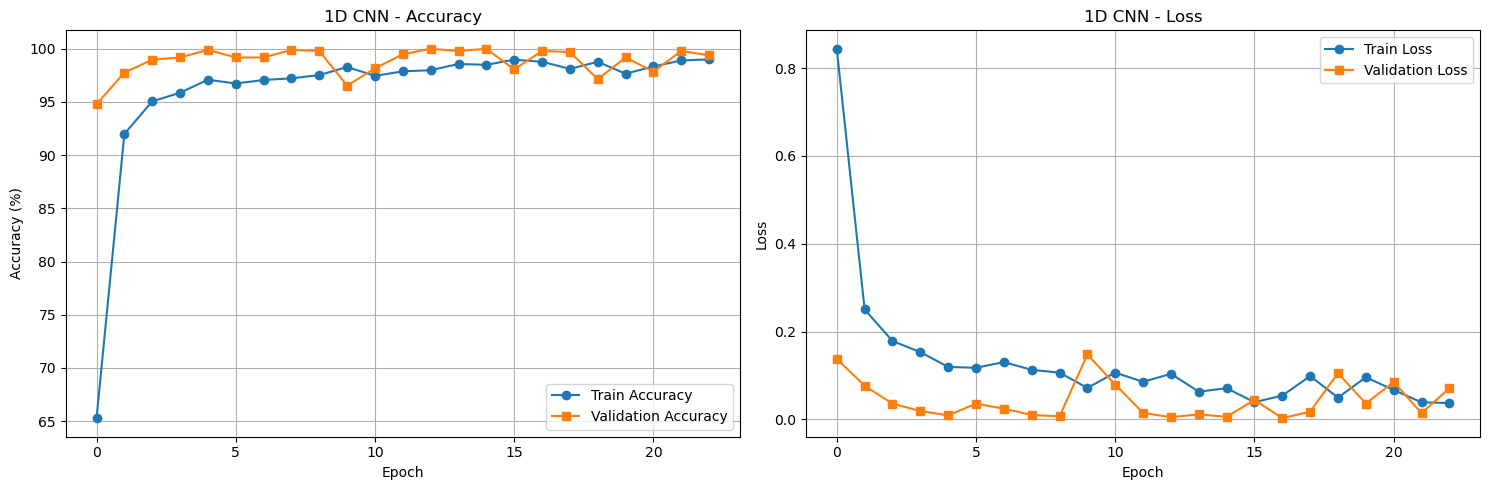


Validation Set Results (used during training)


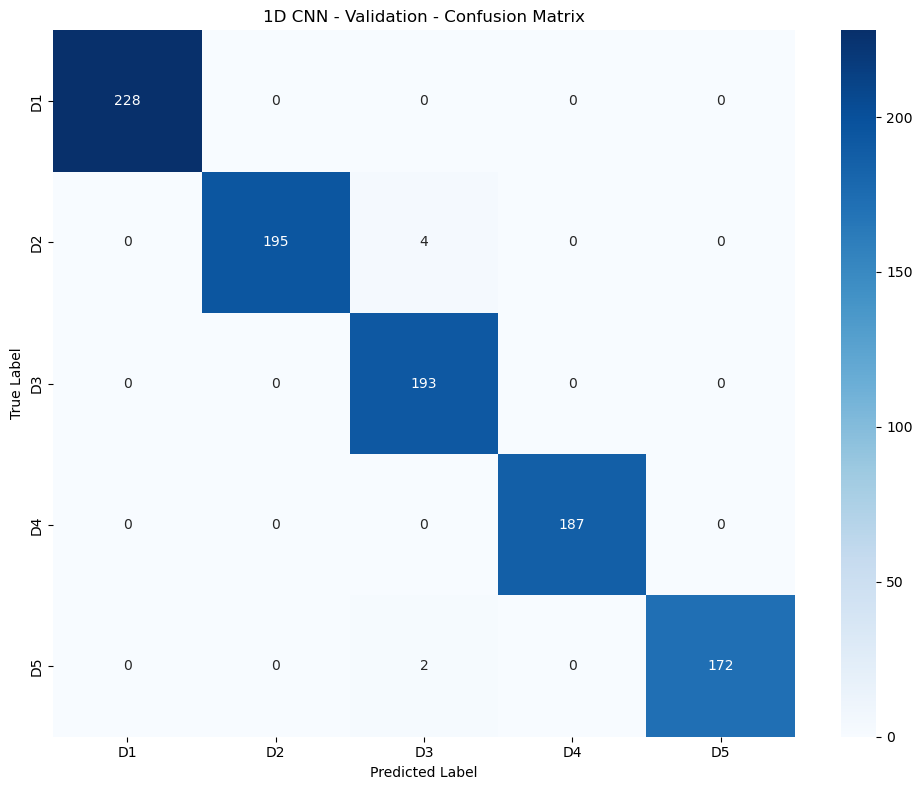


1D CNN - Validation - Classification Report
              precision    recall  f1-score   support

          D1     1.0000    1.0000    1.0000       228
          D2     1.0000    0.9799    0.9898       199
          D3     0.9698    1.0000    0.9847       193
          D4     1.0000    1.0000    1.0000       187
          D5     1.0000    0.9885    0.9942       174

    accuracy                         0.9939       981
   macro avg     0.9940    0.9937    0.9938       981
weighted avg     0.9941    0.9939    0.9939       981


Summary Metrics:
Accuracy:           0.9939
Precision (macro):  0.9940
Recall (macro):     0.9937
F1-Score (macro):  0.9938
Precision (weighted): 0.9941
Recall (weighted):    0.9939
F1-Score (weighted): 0.9939

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
D1         1.0000       1.0000       1.0000       228       
D2         1.0000       0.9799       0.9898       19

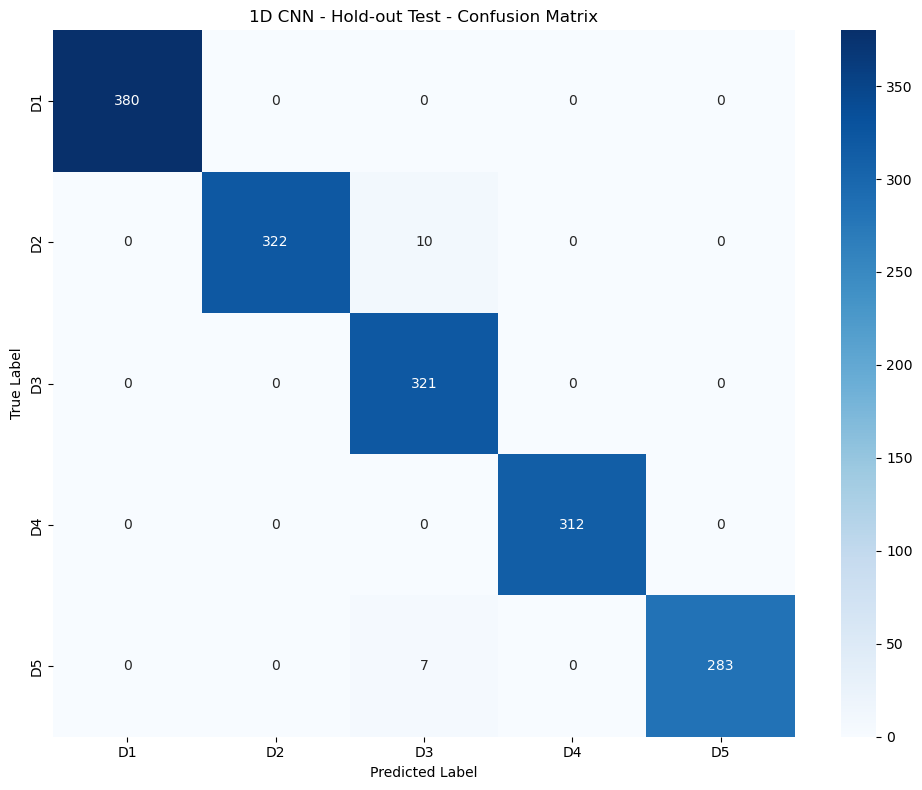


1D CNN - Hold-out Test - Classification Report
              precision    recall  f1-score   support

          D1     1.0000    1.0000    1.0000       380
          D2     1.0000    0.9699    0.9847       332
          D3     0.9497    1.0000    0.9742       321
          D4     1.0000    1.0000    1.0000       312
          D5     1.0000    0.9759    0.9878       290

    accuracy                         0.9896      1635
   macro avg     0.9899    0.9891    0.9893      1635
weighted avg     0.9901    0.9896    0.9897      1635


Summary Metrics:
Accuracy:           0.9896
Precision (macro):  0.9899
Recall (macro):     0.9891
F1-Score (macro):  0.9893
Precision (weighted): 0.9901
Recall (weighted):    0.9896
F1-Score (weighted): 0.9897

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
D1         1.0000       1.0000       1.0000       380       
D2         1.0000       0.9699       0.9847      

{'accuracy': 0.9896024464831804,
 'precision_per_class': array([1.        , 1.        , 0.94970414, 1.        , 1.        ]),
 'recall_per_class': array([1.        , 0.96987952, 1.        , 1.        , 0.97586207]),
 'f1_per_class': array([1.        , 0.98470948, 0.97420334, 1.        , 0.9877836 ]),
 'precision_macro': 0.9899408284023667,
 'recall_macro': 0.9891483174075614,
 'f1_macro': 0.9893392827254528,
 'precision_weighted': 0.9901254003582867,
 'recall_weighted': 0.9896024464831804,
 'f1_weighted': 0.9896636462429241,
 'support': array([380, 332, 321, 312, 290])}

In [13]:
# # Initialize dictionaries to store models and results
# models = {}
# results = {}

# Model 1: 1D CNN
print("\n" + "="*60)
print("MODEL 1: 1D CNN")
print("="*60)

cnn_model = CNN1D(input_channels=num_features, num_classes=num_classes, sequence_length=SEQUENCE_LENGTH)
print(f"\nModel Architecture:")
print(cnn_model)

trained_cnn, cnn_history = train_model(
    cnn_model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    model_name="1D CNN"
)

# Evaluate on validation set (for comparison during training)
criterion = nn.CrossEntropyLoss()
_, _, cnn_val_preds, cnn_val_labels = evaluate(trained_cnn, val_loader, criterion, device)

# Evaluate on hold-out test set (final evaluation)
_, _, cnn_test_preds, cnn_test_labels = evaluate(trained_cnn, test_loader, criterion, device)

# Store results
all_trained_models['CNN1D'] = trained_cnn
all_trained_results['CNN1D'] = {
    'history': cnn_history,
    'val_predictions': cnn_val_preds,
    'val_labels': cnn_val_labels,
    'test_predictions': cnn_test_preds,
    'test_labels': cnn_test_labels,
    'metrics': None  # Will be computed in comparison section
}

# Visualize training history (validation metrics)
plot_training_history(cnn_history, "1D CNN")

# Show validation results
print("\n" + "="*60)
print("Validation Set Results (used during training)")
print("="*60)
plot_confusion_matrix(cnn_val_labels, cnn_val_preds, class_names, "1D CNN - Validation")
print_classification_report(cnn_val_labels, cnn_val_preds, class_names, "1D CNN - Validation")

# Show hold-out test results
print("\n" + "="*60)
print("Hold-out Test Set Results (final evaluation)")
print("="*60)
plot_confusion_matrix(cnn_test_labels, cnn_test_preds, class_names, "1D CNN - Hold-out Test")
print_classification_report(cnn_test_labels, cnn_test_preds, class_names, "1D CNN - Hold-out Test")


MODEL 2: 1D CNN + LSTM

Model Architecture:
CNN_LSTM(
  (activation_fn): ReLU()
  (conv_layers): ModuleList(
    (0): Conv1d(9, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_layers): ModuleList(
    (0-1): 2 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.5, inplace=False)
  )
  (fc_out): 

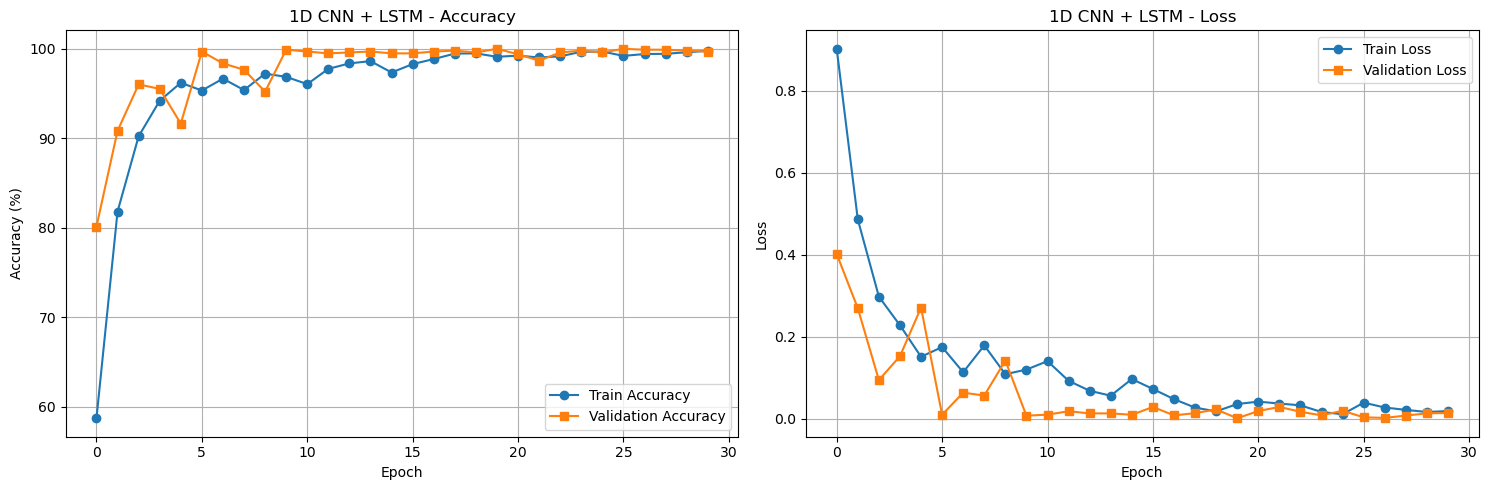


Validation Set Results


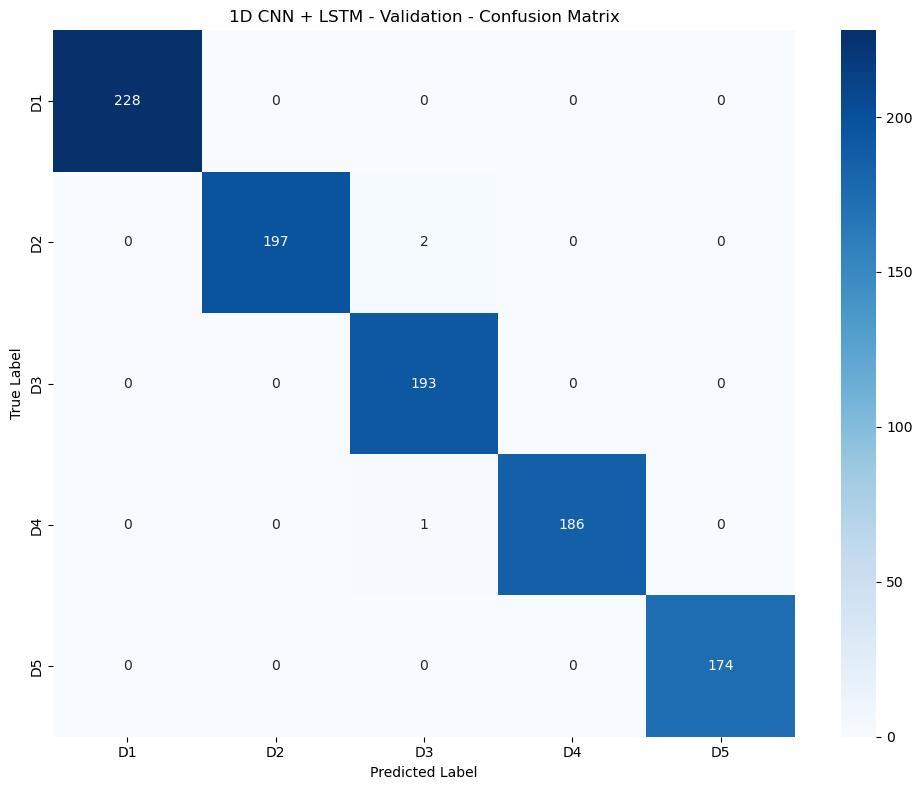


1D CNN + LSTM - Validation - Classification Report
              precision    recall  f1-score   support

          D1     1.0000    1.0000    1.0000       228
          D2     1.0000    0.9899    0.9949       199
          D3     0.9847    1.0000    0.9923       193
          D4     1.0000    0.9947    0.9973       187
          D5     1.0000    1.0000    1.0000       174

    accuracy                         0.9969       981
   macro avg     0.9969    0.9969    0.9969       981
weighted avg     0.9970    0.9969    0.9969       981


Summary Metrics:
Accuracy:           0.9969
Precision (macro):  0.9969
Recall (macro):     0.9969
F1-Score (macro):  0.9969
Precision (weighted): 0.9970
Recall (weighted):    0.9969
F1-Score (weighted): 0.9969

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
D1         1.0000       1.0000       1.0000       228       
D2         1.0000       0.9899       0.9949  

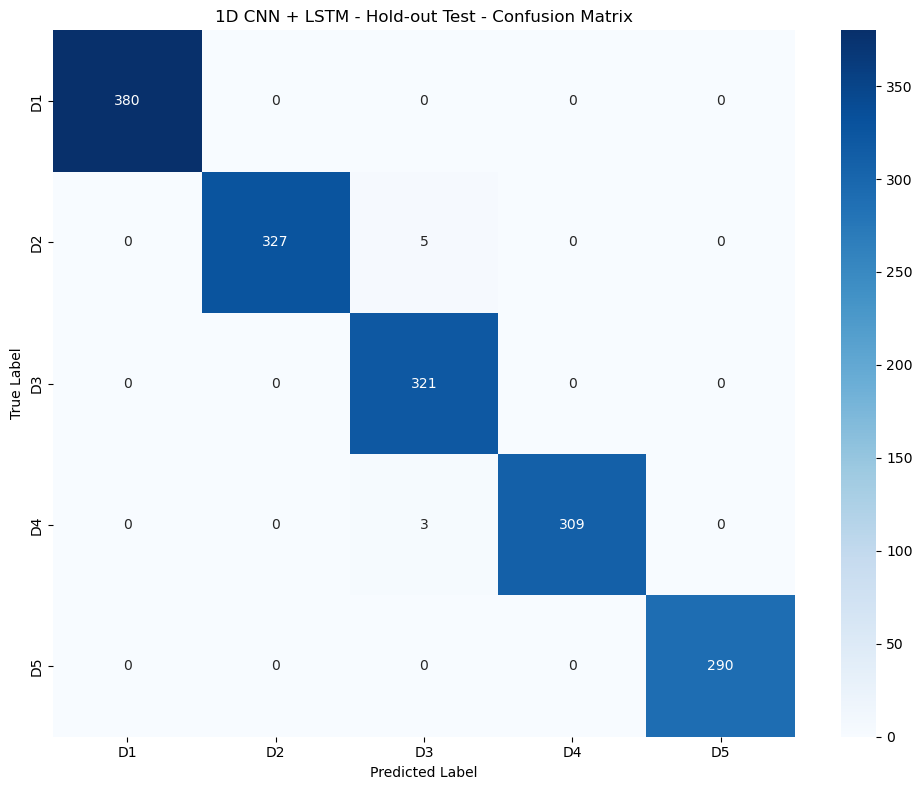


1D CNN + LSTM - Hold-out Test - Classification Report
              precision    recall  f1-score   support

          D1     1.0000    1.0000    1.0000       380
          D2     1.0000    0.9849    0.9924       332
          D3     0.9757    1.0000    0.9877       321
          D4     1.0000    0.9904    0.9952       312
          D5     1.0000    1.0000    1.0000       290

    accuracy                         0.9951      1635
   macro avg     0.9951    0.9951    0.9951      1635
weighted avg     0.9952    0.9951    0.9951      1635


Summary Metrics:
Accuracy:           0.9951
Precision (macro):  0.9951
Recall (macro):     0.9951
F1-Score (macro):  0.9951
Precision (weighted): 0.9952
Recall (weighted):    0.9951
F1-Score (weighted): 0.9951

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
D1         1.0000       1.0000       1.0000       380       
D2         1.0000       0.9849       0.992

{'accuracy': 0.9951070336391438,
 'precision_per_class': array([1.        , 1.        , 0.97568389, 1.        , 1.        ]),
 'recall_per_class': array([1.        , 0.98493976, 1.        , 0.99038462, 1.        ]),
 'f1_per_class': array([1.        , 0.99241275, 0.98769231, 0.99516908, 1.        ]),
 'precision_macro': 0.9951367781155016,
 'recall_macro': 0.995064874884152,
 'f1_macro': 0.9950548272807295,
 'precision_weighted': 0.9952260115445749,
 'recall_weighted': 0.9951070336391438,
 'f1_weighted': 0.9951211108617023,
 'support': array([380, 332, 321, 312, 290])}

In [14]:
# Model 2: 1D CNN + LSTM
print("\n" + "="*60)
print("MODEL 2: 1D CNN + LSTM")
print("="*60)

cnn_lstm_model = CNN_LSTM(
    input_channels=num_features, 
    num_classes=num_classes, 
    sequence_length=SEQUENCE_LENGTH,
    **CNN_LSTM_CONFIG  # Unpack hyperparameter configuration
)
print(f"\nModel Architecture:")
print(cnn_lstm_model)
print(f"\nHyperparameters used:")
for key, value in CNN_LSTM_CONFIG.items():
    print(f"  {key}: {value}")

trained_cnn_lstm, cnn_lstm_history = train_model(
    cnn_lstm_model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    model_name="1D CNN + LSTM"
)

# Evaluate on validation and test sets
_, _, cnn_lstm_val_preds, cnn_lstm_val_labels = evaluate(trained_cnn_lstm, val_loader, criterion, device)
_, _, cnn_lstm_test_preds, cnn_lstm_test_labels = evaluate(trained_cnn_lstm, test_loader, criterion, device)

# Store results
all_trained_models['CNN_LSTM'] = trained_cnn_lstm
all_trained_results['CNN_LSTM'] = {
    'history': cnn_lstm_history,
    'val_predictions': cnn_lstm_val_preds,
    'val_labels': cnn_lstm_val_labels,
    'test_predictions': cnn_lstm_test_preds,
    'test_labels': cnn_lstm_test_labels,
    'metrics': None  # Will be computed in comparison section
}

# Visualize
plot_training_history(cnn_lstm_history, "1D CNN + LSTM")
print("\n" + "="*60)
print("Validation Set Results")
print("="*60)
plot_confusion_matrix(cnn_lstm_val_labels, cnn_lstm_val_preds, class_names, "1D CNN + LSTM - Validation")
print_classification_report(cnn_lstm_val_labels, cnn_lstm_val_preds, class_names, "1D CNN + LSTM - Validation")
print("\n" + "="*60)
print("Hold-out Test Set Results")
print("="*60)
plot_confusion_matrix(cnn_lstm_test_labels, cnn_lstm_test_preds, class_names, "1D CNN + LSTM - Hold-out Test")
print_classification_report(cnn_lstm_test_labels, cnn_lstm_test_preds, class_names, "1D CNN + LSTM - Hold-out Test")


MODEL 3: 1D CNN + Transformer

Model Architecture:
CNN_Transformer(
  (activation_fn): ReLU()
  (conv_layers): ModuleList(
    (0): Conv1d(9, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_layers): ModuleList(
    (0-1): 2 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.3, inplace=False)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_featu

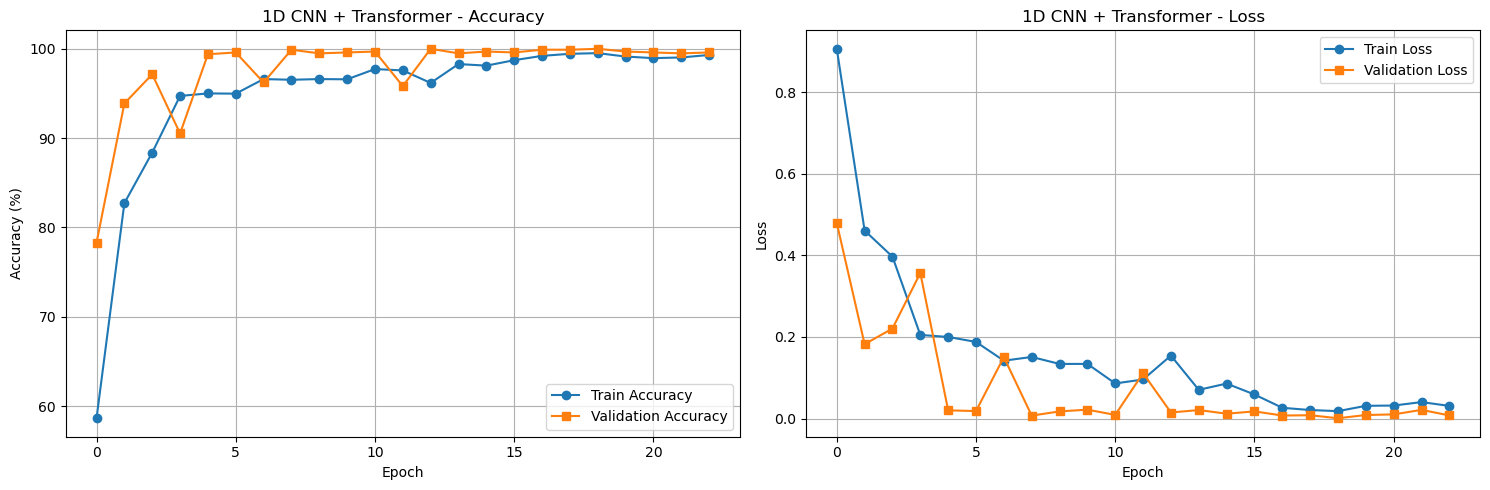


Validation Set Results


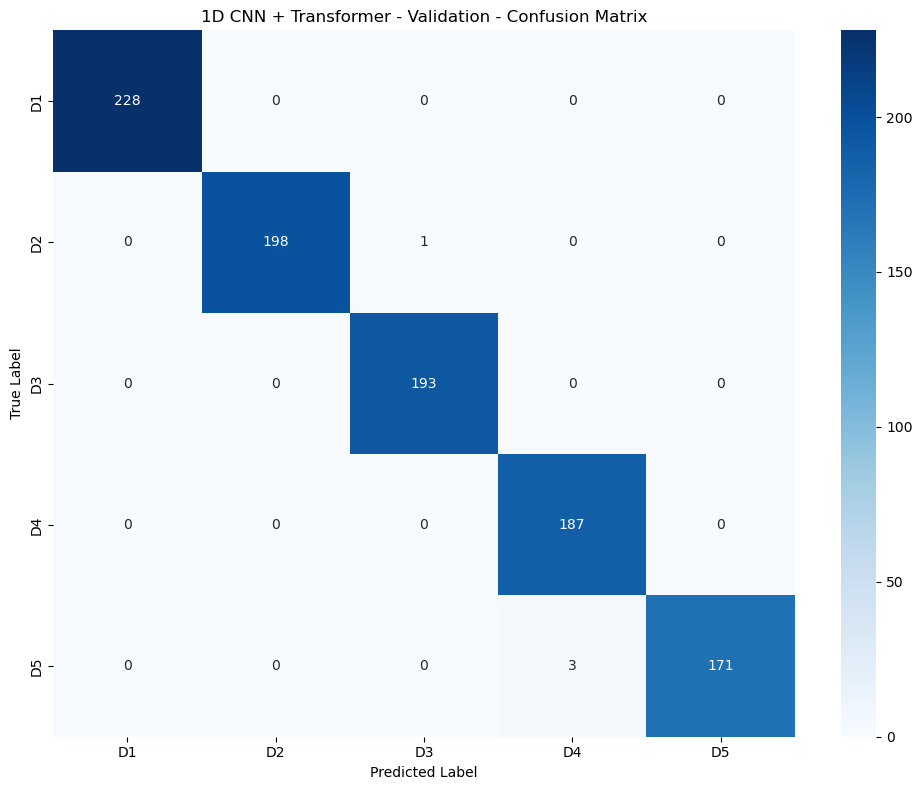


1D CNN + Transformer - Validation - Classification Report
              precision    recall  f1-score   support

          D1     1.0000    1.0000    1.0000       228
          D2     1.0000    0.9950    0.9975       199
          D3     0.9948    1.0000    0.9974       193
          D4     0.9842    1.0000    0.9920       187
          D5     1.0000    0.9828    0.9913       174

    accuracy                         0.9959       981
   macro avg     0.9958    0.9955    0.9956       981
weighted avg     0.9960    0.9959    0.9959       981


Summary Metrics:
Accuracy:           0.9959
Precision (macro):  0.9958
Recall (macro):     0.9955
F1-Score (macro):  0.9956
Precision (weighted): 0.9960
Recall (weighted):    0.9959
F1-Score (weighted): 0.9959

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
D1         1.0000       1.0000       1.0000       228       
D2         1.0000       0.9950       0

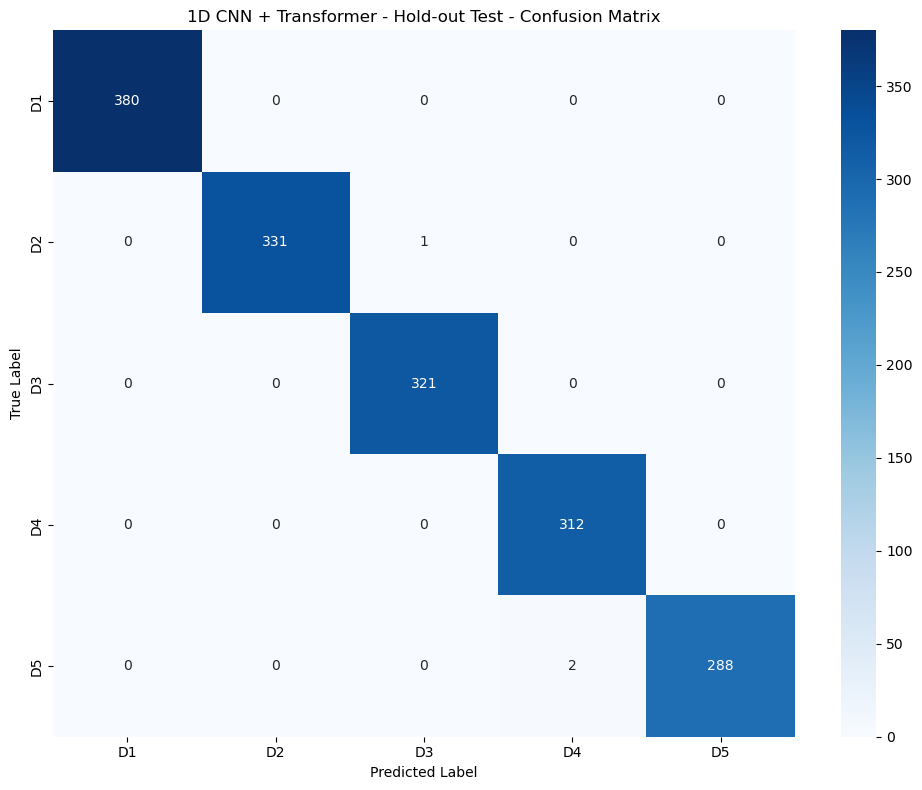


1D CNN + Transformer - Hold-out Test - Classification Report
              precision    recall  f1-score   support

          D1     1.0000    1.0000    1.0000       380
          D2     1.0000    0.9970    0.9985       332
          D3     0.9969    1.0000    0.9984       321
          D4     0.9936    1.0000    0.9968       312
          D5     1.0000    0.9931    0.9965       290

    accuracy                         0.9982      1635
   macro avg     0.9981    0.9980    0.9981      1635
weighted avg     0.9982    0.9982    0.9982      1635


Summary Metrics:
Accuracy:           0.9982
Precision (macro):  0.9981
Recall (macro):     0.9980
F1-Score (macro):  0.9981
Precision (weighted): 0.9982
Recall (weighted):    0.9982
F1-Score (weighted): 0.9982

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
D1         1.0000       1.0000       1.0000       380       
D2         1.0000       0.9970     

{'accuracy': 0.998165137614679,
 'precision_per_class': array([1.        , 1.        , 0.99689441, 0.99363057, 1.        ]),
 'recall_per_class': array([1.        , 0.99698795, 1.        , 1.        , 0.99310345]),
 'f1_per_class': array([1.        , 0.9984917 , 0.99844479, 0.99680511, 0.99653979]),
 'precision_macro': 0.9981049966372592,
 'recall_macro': 0.9980182800166182,
 'f1_macro': 0.9980562797258686,
 'precision_weighted': 0.9981748284058504,
 'recall_weighted': 0.998165137614679,
 'f1_weighted': 0.9981649896866851,
 'support': array([380, 332, 321, 312, 290])}

In [15]:
# Model 3: 1D CNN + Transformer
print("\n" + "="*60)
print("MODEL 3: 1D CNN + Transformer")
print("="*60)

cnn_transformer_model = CNN_Transformer(
    input_channels=num_features,
    num_classes=num_classes,
    sequence_length=SEQUENCE_LENGTH,
    **CNN_TRANSFORMER_CONFIG  # Unpack hyperparameter configuration
)
print(f"\nModel Architecture:")
print(cnn_transformer_model)
print(f"\nHyperparameters used:")
for key, value in CNN_TRANSFORMER_CONFIG.items():
    print(f"  {key}: {value}")

trained_cnn_transformer, cnn_transformer_history = train_model(
    cnn_transformer_model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    model_name="1D CNN + Transformer"
)

# Evaluate on validation and test sets
_, _, cnn_transformer_val_preds, cnn_transformer_val_labels = evaluate(
    trained_cnn_transformer, val_loader, criterion, device
)
_, _, cnn_transformer_test_preds, cnn_transformer_test_labels = evaluate(
    trained_cnn_transformer, test_loader, criterion, device
)

# Store results
all_trained_models['CNN_Transformer'] = trained_cnn_transformer
all_trained_results['CNN_Transformer'] = {
    'history': cnn_transformer_history,
    'val_predictions': cnn_transformer_val_preds,
    'val_labels': cnn_transformer_val_labels,
    'test_predictions': cnn_transformer_test_preds,
    'test_labels': cnn_transformer_test_labels,
    'metrics': None  # Will be computed in comparison section
}

# Visualize
plot_training_history(cnn_transformer_history, "1D CNN + Transformer")
print("\n" + "="*60)
print("Validation Set Results")
print("="*60)
plot_confusion_matrix(cnn_transformer_val_labels, cnn_transformer_val_preds, class_names, "1D CNN + Transformer - Validation")
print_classification_report(cnn_transformer_val_labels, cnn_transformer_val_preds, class_names, "1D CNN + Transformer - Validation")
print("\n" + "="*60)
print("Hold-out Test Set Results")
print("="*60)
plot_confusion_matrix(cnn_transformer_test_labels, cnn_transformer_test_preds, class_names, "1D CNN + Transformer - Hold-out Test")
print_classification_report(cnn_transformer_test_labels, cnn_transformer_test_preds, class_names, "1D CNN + Transformer - Hold-out Test")

## 5. Model Comparison


MODEL COMPARISON - COMPREHENSIVE METRICS

Model Performance Comparison:
          Model  Accuracy (Test)  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  F1-Score (Weighted)  Best Val Acc (%)
          CNN1D         0.989602           0.989941        0.989148          0.989339             0.989664             100.0
       CNN_LSTM         0.995107           0.995137        0.995065          0.995055             0.995121             100.0
CNN_Transformer         0.998165           0.998105        0.998018          0.998056             0.998165             100.0


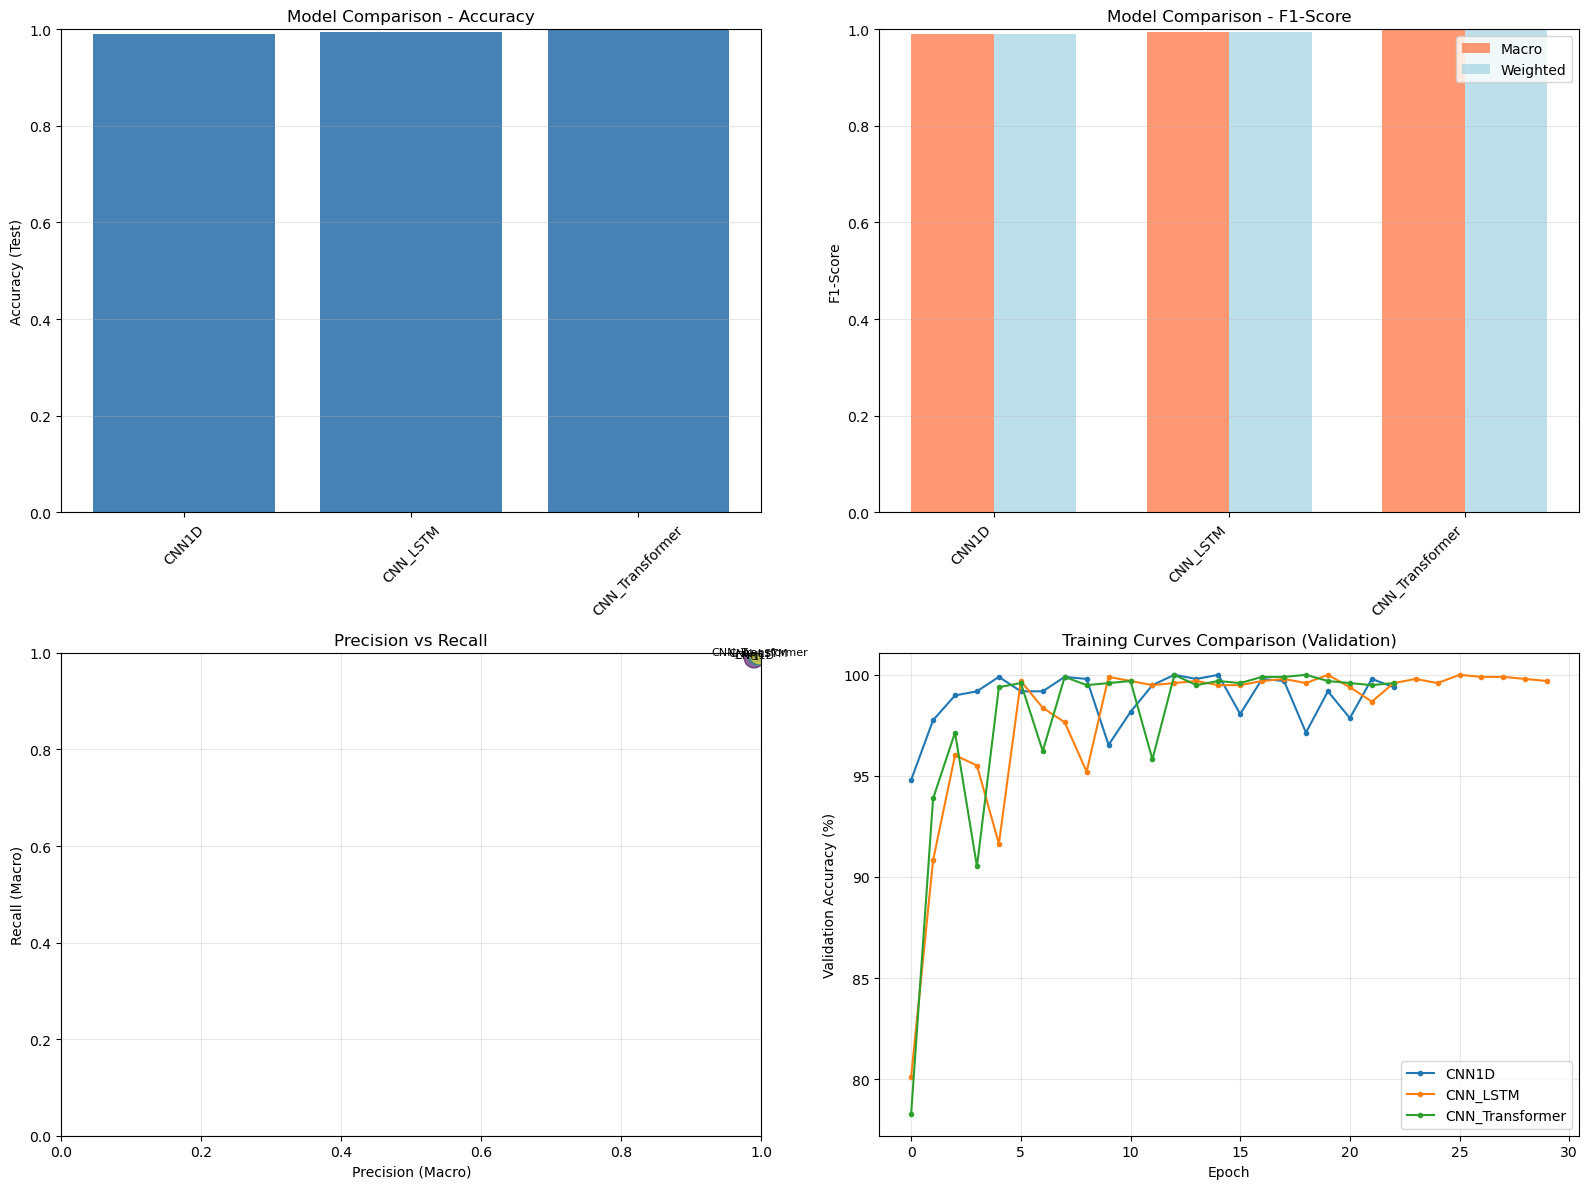

In [16]:
# Compare all models with comprehensive metrics
print("\n" + "="*60)
print("MODEL COMPARISON - COMPREHENSIVE METRICS")
print("="*60)

comparison_data = []
for model_name, result in all_trained_results.items():
    # Use hold-out test set metrics for comparison
    test_metrics = compute_comprehensive_metrics(result['test_labels'], result['test_predictions'], class_names)
    best_val_acc = max(result['history']['val_acc'])
    
    comparison_data.append({
        'Model': model_name,
        'Accuracy (Test)': test_metrics['accuracy'],
        'Precision (Macro)': test_metrics['precision_macro'],
        'Recall (Macro)': test_metrics['recall_macro'],
        'F1-Score (Macro)': test_metrics['f1_macro'],
        'F1-Score (Weighted)': test_metrics['f1_weighted'],
        'Best Val Acc (%)': best_val_acc
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Store metrics for each model (both validation and test)
for model_name, result in all_trained_results.items():
    all_trained_results[model_name]['val_metrics'] = compute_comprehensive_metrics(
        result['val_labels'], result['val_predictions'], class_names
    )
    all_trained_results[model_name]['test_metrics'] = compute_comprehensive_metrics(
        result['test_labels'], result['test_predictions'], class_names
    )

# Plot comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy (Test)'], color='steelblue')
axes[0, 0].set_ylabel('Accuracy (Test)')
axes[0, 0].set_title('Model Comparison - Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# 2. F1-Score comparison
x_pos = np.arange(len(comparison_df))
width = 0.35
axes[0, 1].bar(x_pos - width/2, comparison_df['F1-Score (Macro)'], width, 
               label='Macro', color='coral', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, comparison_df['F1-Score (Weighted)'], width, 
               label='Weighted', color='lightblue', alpha=0.8)
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('Model Comparison - F1-Score')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# 3. Precision vs Recall
axes[1, 0].scatter(comparison_df['Precision (Macro)'], comparison_df['Recall (Macro)'], 
                   s=200, alpha=0.6, c=range(len(comparison_df)), cmap='viridis')
for i, model in enumerate(comparison_df['Model']):
    axes[1, 0].annotate(model, 
                       (comparison_df['Precision (Macro)'][i], comparison_df['Recall (Macro)'][i]),
                       fontsize=8, ha='center')
axes[1, 0].set_xlabel('Precision (Macro)')
axes[1, 0].set_ylabel('Recall (Macro)')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])

# 4. Training curves comparison (validation accuracy)
for model_name, result in all_trained_results.items():
    axes[1, 1].plot(result['history']['val_acc'], label=model_name, marker='o', markersize=3)

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy (%)')
axes[1, 1].set_title('Training Curves Comparison (Validation)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model Saving and Loading

In [17]:
# Save models and training results for Streamlit dashboard
import os
import pickle

os.makedirs('saved_models_pytorch', exist_ok=True)

# ============================================================================
# Save Models with Hyperparameters AND Preprocessing Configuration
# ============================================================================

# Create preprocessing configuration dictionary from selected preprocessing config
# This ensures the saved configuration matches what was used during training
preprocessing_config = {
    'normalization': NORMALIZATION,
    'window_stride': WINDOW_STRIDE,
    'handle_drift': HANDLE_DRIFT,
    'drift_method': DRIFT_METHOD if HANDLE_DRIFT else None,
    'sequence_length': SEQUENCE_LENGTH,
    'num_features': num_features,
    'preprocessing_name': SELECTED_PREPROCESSING  # Store which preprocessing config was used
}

# Save scaler(s) separately (they can be large)
scaler_path = 'saved_models_pytorch/preprocessing_scaler.pkl'
if scaler is not None:
    with open(scaler_path, 'wb') as f:
        pickle.dump({
            'scaler': scaler,
            'normalization': NORMALIZATION,
            'num_features': num_features
        }, f)
    print(f"Saved scaler to {scaler_path}")
else:
    print("No scaler to save (normalization='none')")

# Map current model names to configuration names from MODEL_CONFIGURATIONS
# This maps the 3 base models to their corresponding configuration names
model_to_config_name = {
    'CNN1D': 'cnn1d_base',
    'CNN_LSTM': 'cnn_lstm_base',
    'CNN_Transformer': 'cnn_transformer_base'
}

# Save hyperparameter configurations with models
hyperparameter_configs = {
    'CNN1D': CNN1D_CONFIG,
    'CNN_LSTM': CNN_LSTM_CONFIG,
    'CNN_Transformer': CNN_TRANSFORMER_CONFIG
}

for model_name, model in all_trained_models.items():
    # Get configuration name from mapping
    config_name = model_to_config_name.get(model_name, model_name.lower().replace(' ', '_'))
    model_path = f'saved_models_pytorch/{config_name}.pth'
    config_key = model_name.replace(' ', '_')
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_class': model.__class__.__name__,
        'input_channels': num_features,
        'num_classes': num_classes,
        'sequence_length': SEQUENCE_LENGTH,
        'class_names': class_names,
        'hyperparameters': hyperparameter_configs.get(config_key, {}),  # Model hyperparameters
        'preprocessing_config': preprocessing_config,  # Preprocessing configuration
        'scaler_path': scaler_path if scaler is not None else None,  # Path to scaler file
        'config_name': config_name  # Configuration name for identification in Streamlit
    }, model_path)
    print(f"Saved {model_name} as '{config_name}' to {model_path}")
    print(f"  Hyperparameters: {hyperparameter_configs.get(config_key, {})}")
    print(f"  Preprocessing: {preprocessing_config}")

# Save training results for Streamlit dashboard (using configuration names)
training_results = {}
for model_name, result in all_trained_results.items():
    # Use configuration name for training results
    config_name = model_to_config_name.get(model_name, model_name.lower().replace(' ', '_'))
    training_results[config_name] = {
        'history': result['history'],
        'test_labels': result['test_labels'],
        'test_predictions': result['test_predictions'],
        'test_metrics': result.get('test_metrics', {}),
        'val_labels': result.get('val_labels', []),
        'val_predictions': result.get('val_predictions', []),
        'class_names': class_names
    }

with open('training_results.pkl', 'wb') as f:
    pickle.dump(training_results, f)

print("\n" + "="*60)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)
print(f"\nSaved {len(all_trained_models)} model configurations:")
for model_name, config_name in model_to_config_name.items():
    if model_name in all_trained_models:
        print(f"  ✅ {model_name} -> '{config_name}'")

print("\nTraining results saved to 'training_results.pkl' for Streamlit dashboard")
print("\n📦 Saved with each model:")
print("   ✅ Model hyperparameters (filters, kernels, activation, dropout, etc.)")
print("   ✅ Preprocessing configuration (normalization, drift handling, windowing)")
print("   ✅ Scaler object (saved separately in 'preprocessing_scaler.pkl')")
print("   ✅ Configuration name for identification in Streamlit")
print("\n💡 You can now run the Streamlit dashboard:")
print("   streamlit run streamlit_DL_app.py")
print("\n⚠️  IMPORTANT: The Streamlit app loads and compares all saved configurations")
print("   No training happens in Streamlit - only inference and visualization!")

Saved scaler to saved_models_pytorch/preprocessing_scaler.pkl
Saved CNN1D as 'cnn1d_base' to saved_models_pytorch/cnn1d_base.pth
  Hyperparameters: {'filters': [64, 128, 256], 'kernel_sizes': [5, 5, 3], 'fc_sizes': [128, 64], 'dropout_conv': 0.3, 'dropout_fc': 0.5, 'activation': 'relu', 'use_batch_norm': True, 'pool_size': 2}
  Preprocessing: {'normalization': 'standard', 'window_stride': None, 'handle_drift': False, 'drift_method': None, 'sequence_length': 100, 'num_features': 9, 'preprocessing_name': 'prep_base'}
Saved CNN_LSTM as 'cnn_lstm_base' to saved_models_pytorch/cnn_lstm_base.pth
  Hyperparameters: {'cnn_filters': [64, 128], 'cnn_kernel_sizes': [5, 5], 'lstm_hidden': 128, 'lstm_layers': 2, 'lstm_bidirectional': True, 'fc_sizes': [128, 64], 'dropout_conv': 0.3, 'dropout_lstm': 0.3, 'dropout_fc': 0.5, 'activation': 'relu', 'use_batch_norm': True, 'pool_size': 2}
  Preprocessing: {'normalization': 'standard', 'window_stride': None, 'handle_drift': False, 'drift_method': None, 's

In [18]:
# Example: Load and test a saved model with preprocessing config
def load_model(model_path, model_class_map):
    """
    Load a saved model with hyperparameters and preprocessing configuration.
    
    Args:
        model_path: Path to saved model
        model_class_map: Dictionary mapping model class names to classes
    
    Returns:
        Loaded model, metadata (including hyperparameters), preprocessing config, and scaler
    """
    checkpoint = torch.load(model_path, map_location=device)
    
    model_class_name = checkpoint['model_class']
    model_class = model_class_map[model_class_name]
    
    # Get hyperparameters from checkpoint (if saved) or use defaults
    hyperparams = checkpoint.get('hyperparameters', {})
    
    # Get preprocessing configuration
    preprocessing_config = checkpoint.get('preprocessing_config', {})
    
    # Load scaler if available
    scaler = None
    scaler_path = checkpoint.get('scaler_path')
    if scaler_path and os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler_data = pickle.load(f)
            scaler = scaler_data['scaler']
        print(f"Loaded scaler from {scaler_path}")
    
    # Recreate model with saved hyperparameters
    if model_class_name == 'CNN1D':
        default_params = {
            'filters': [64, 128, 256],
            'kernel_sizes': [5, 5, 3],
            'fc_sizes': [128, 64],
            'dropout_conv': 0.3,
            'dropout_fc': 0.5,
            'activation': 'relu',
            'use_batch_norm': True,
            'pool_size': 2
        }
        default_params.update(hyperparams)
        model = model_class(
            input_channels=checkpoint['input_channels'],
            num_classes=checkpoint['num_classes'],
            sequence_length=checkpoint['sequence_length'],
            **default_params
        )
    elif model_class_name == 'CNN_LSTM':
        default_params = {
            'cnn_filters': [64, 128],
            'cnn_kernel_sizes': [5, 5],
            'lstm_hidden': 128,
            'lstm_layers': 2,
            'lstm_bidirectional': True,
            'fc_sizes': [128, 64],
            'dropout_conv': 0.3,
            'dropout_lstm': 0.3,
            'dropout_fc': 0.5,
            'activation': 'relu',
            'use_batch_norm': True,
            'pool_size': 2
        }
        default_params.update(hyperparams)
        model = model_class(
            input_channels=checkpoint['input_channels'],
            num_classes=checkpoint['num_classes'],
            sequence_length=checkpoint['sequence_length'],
            **default_params
        )
    elif model_class_name == 'CNN_Transformer':
        default_params = {
            'cnn_filters': [64, 128],
            'cnn_kernel_sizes': [5, 5],
            'd_model': 128,
            'nhead': 8,
            'num_layers': 2,
            'dim_feedforward': 512,
            'fc_sizes': [128, 64],
            'dropout_conv': 0.3,
            'dropout_transformer': 0.1,
            'dropout_fc': 0.5,
            'activation': 'relu',
            'use_batch_norm': True,
            'pool_size': 2
        }
        default_params.update(hyperparams)
        model = model_class(
            input_channels=checkpoint['input_channels'],
            num_classes=checkpoint['num_classes'],
            sequence_length=checkpoint['sequence_length'],
            **default_params
        )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, checkpoint, preprocessing_config, scaler


def preprocess_for_inference(sensor_data, preprocessing_config, scaler=None):
    """
    Preprocess sensor data for inference using saved preprocessing configuration.
    
    Args:
        sensor_data: Raw sensor data (numpy array)
        preprocessing_config: Dictionary with preprocessing settings
        scaler: Fitted scaler object (if normalization was used)
    
    Returns:
        Preprocessed sensor data ready for model input
    """
    sensor_data = sensor_data.copy()
    sequence_length = preprocessing_config.get('sequence_length', 100)
    
    # Apply drift compensation if it was used during training
    if preprocessing_config.get('handle_drift', False):
        drift_method = preprocessing_config.get('drift_method', 'baseline')
        
        if drift_method == 'baseline':
            baseline = sensor_data[0, :] if sensor_data.ndim == 2 else sensor_data[0]
            sensor_data = sensor_data - baseline
        elif drift_method == 'relative':
            baseline = sensor_data[0, :] if sensor_data.ndim == 2 else sensor_data[0]
            baseline = np.where(baseline == 0, 1, baseline)
            if sensor_data.ndim == 2:
                sensor_data = (sensor_data - baseline) / baseline
            else:
                sensor_data = (sensor_data - baseline) / baseline
        elif drift_method == 'moving_baseline':
            window_size = min(10, sequence_length // 10)
            if sensor_data.ndim == 2:
                baseline = np.mean(sensor_data[:window_size, :], axis=0)
            else:
                baseline = np.mean(sensor_data[:window_size])
            sensor_data = sensor_data - baseline
    
    # Apply normalization if it was used during training
    if scaler is not None and preprocessing_config.get('normalization', 'none') != 'none':
        normalization = preprocessing_config.get('normalization', 'standard')
        
        if normalization == 'per_sensor':
            # Per-sensor normalization
            if sensor_data.ndim == 2:
                n_samples, n_features = sensor_data.shape
                sensor_scaled = np.zeros_like(sensor_data)
                for sensor_idx in range(n_features):
                    sensor_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                        sensor_data[:, sensor_idx].reshape(-1, 1)
                    ).flatten()
                sensor_data = sensor_scaled
            else:
                # Single sensor
                sensor_data = scaler[0].transform(sensor_data.reshape(-1, 1)).flatten()
        else:
            # Global normalization
            if sensor_data.ndim == 2:
                sensor_data = scaler.transform(sensor_data)
            else:
                sensor_data = scaler.transform(sensor_data.reshape(-1, 1)).flatten()
    
    # Ensure correct shape and length
    if sensor_data.ndim == 1:
        # Single row, pad or truncate to sequence_length
        if len(sensor_data) < sequence_length:
            # Pad with zeros
            padding = np.zeros((sequence_length - len(sensor_data),))
            sensor_data = np.concatenate([sensor_data, padding])
        else:
            sensor_data = sensor_data[:sequence_length]
        # Reshape to (1, sequence_length, num_features)
        num_features = preprocessing_config.get('num_features', sensor_data.shape[-1])
        sensor_data = sensor_data.reshape(1, sequence_length, num_features)
    elif sensor_data.ndim == 2:
        # 2D array: (time_steps, features)
        if sensor_data.shape[0] < sequence_length:
            # Pad with zeros
            padding = np.zeros((sequence_length - sensor_data.shape[0], sensor_data.shape[1]))
            sensor_data = np.vstack([sensor_data, padding])
        else:
            sensor_data = sensor_data[:sequence_length]
        # Reshape to (1, sequence_length, num_features)
        sensor_data = sensor_data.reshape(1, sequence_length, -1)
    
    return sensor_data.astype(np.float32)

# Example usage
model_class_map = {
    'CNN1D': CNN1D,
    'CNN_LSTM': CNN_LSTM,
    'CNN_Transformer': CNN_Transformer
}

# Uncomment to test loading
# loaded_model, metadata = load_model('saved_models_pytorch/cnn1d.pth', model_class_map)
# print(f"Loaded model: {metadata['model_class']}")
# print(f"Classes: {metadata['class_names']}")

## 7. Inference Function

Function to make predictions on new data.

In [19]:
def predict_freshness(model, sensor_data, device, class_names, 
                     preprocessing_config=None, scaler=None, sequence_length=100):
    """
    Predict fruit freshness from sensor data with proper preprocessing.
    
    Args:
        model: Trained PyTorch model
        sensor_data: Raw sensor readings (numpy array)
        device: Device to run inference on
        class_names: List of class names
        preprocessing_config: Dictionary with preprocessing settings (from saved model)
        scaler: Fitted scaler object (from saved model)
        sequence_length: Expected sequence length (fallback if preprocessing_config not provided)
    
    Returns:
        predicted_class: Predicted class name
        probabilities: Dictionary of class probabilities
    """
    model.eval()
    
    # Use preprocessing_config if provided, otherwise fall back to simple padding
    if preprocessing_config is not None:
        # Use saved preprocessing configuration
        preprocessed_data = preprocess_for_inference(sensor_data, preprocessing_config, scaler)
    else:
        # Legacy mode: simple padding/truncation (no normalization or drift compensation)
        if sensor_data.ndim == 1:
            if len(sensor_data) < sequence_length:
                sensor_data = np.pad(sensor_data, (0, sequence_length - len(sensor_data)), 
                                   mode='constant', constant_values=0)
            else:
                sensor_data = sensor_data[:sequence_length]
            sensor_data = sensor_data.reshape(1, sequence_length, -1)
        elif sensor_data.ndim == 2:
            if sensor_data.shape[0] < sequence_length:
                padding = np.zeros((sequence_length - sensor_data.shape[0], sensor_data.shape[1]))
                sensor_data = np.vstack([sensor_data, padding])
            else:
                sensor_data = sensor_data[:sequence_length]
            sensor_data = sensor_data.reshape(1, sequence_length, -1)
        preprocessed_data = sensor_data.astype(np.float32)
    
    sensor_tensor = torch.FloatTensor(preprocessed_data).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(sensor_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
    
    # Get probabilities for all classes
    prob_dict = {class_names[i]: probabilities[0][i].item() for i in range(len(class_names))}
    
    return class_names[predicted_idx], prob_dict


# Example: Test prediction on a sample from test set
# Load a saved model to demonstrate proper preprocessing
print("="*60)
print("EXAMPLE: Loading Model and Making Predictions")
print("="*60)

# Example: Load a saved model
model_class_map = {
    'CNN1D': CNN1D,
    'CNN_LSTM': CNN_LSTM,
    'CNN_Transformer': CNN_Transformer
}

# Load the first saved model as an example
saved_models = [f for f in os.listdir('saved_models_pytorch') if f.endswith('.pth')]
if saved_models:
    example_model_path = f'saved_models_pytorch/{saved_models[0]}'
    print(f"\nLoading model: {example_model_path}")
    loaded_model, checkpoint, prep_config, loaded_scaler = load_model(
        example_model_path, 
        model_class_map
    )
    
    print(f"\nModel loaded successfully!")
    print(f"  Preprocessing config: {prep_config}")
    print(f"  Scaler loaded: {loaded_scaler is not None}")
    
    # Test prediction with proper preprocessing
    sample_sequence, sample_label = test_dataset[0]
    # Get raw data (before preprocessing) - simulate real-world scenario
    # In practice, you'd get raw sensor readings
    raw_sample = sample_sequence.numpy()
    
    predicted_class, probabilities = predict_freshness(
        loaded_model, 
        raw_sample, 
        device, 
        checkpoint['class_names'],
        preprocessing_config=prep_config,
        scaler=loaded_scaler
    )
    
    print(f"\nSample Prediction (with proper preprocessing):")
    print(f"  True Label: {checkpoint['class_names'][sample_label.item()]}")
    print(f"  Predicted Label: {predicted_class}")
    print(f"  Probabilities:")
    for cls, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        print(f"    {cls}: {prob:.4f}")
else:
    print("\nNo saved models found. Train models first to see this example.")
    print("Using current model for demonstration:")
    sample_sequence, sample_label = test_dataset[0]
    predicted_class, probabilities = predict_freshness(
        all_trained_models['CNN1D'], 
        sample_sequence.numpy(), 
        device, 
        class_names,
        preprocessing_config=preprocessing_config,
        scaler=scaler
    )
    
    print(f"\nSample Prediction:")
    print(f"  True Label: {class_names[sample_label.item()]}")
    print(f"  Predicted Label: {predicted_class}")
    print(f"  Probabilities:")
    for cls, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        print(f"    {cls}: {prob:.4f}")

EXAMPLE: Loading Model and Making Predictions

Loading model: saved_models_pytorch/cnn_transformer_base.pth
Loaded scaler from saved_models_pytorch/preprocessing_scaler.pkl

Model loaded successfully!
  Preprocessing config: {'normalization': 'standard', 'window_stride': None, 'handle_drift': False, 'drift_method': None, 'sequence_length': 100, 'num_features': 9, 'preprocessing_name': 'prep_base'}
  Scaler loaded: True

Sample Prediction (with proper preprocessing):
  True Label: D1
  Predicted Label: D1
  Probabilities:
    D1: 1.0000
    D3: 0.0000
    D4: 0.0000
    D5: 0.0000
    D2: 0.0000


## 8. Decision Rules for Quality Control

Based on the model predictions, we can define decision rules for quality control in real-world scenarios.

In [21]:

class QualityControlDecision:
    """
    Decision rules for fruit quality control based on freshness predictions.
    """
    def __init__(self, model, device, class_names):
        self.model = model
        self.device = device
        self.class_names = class_names
    
    def make_decision(self, sensor_data, confidence_threshold=0.7):
        """
        Make quality control decision based on predicted freshness.
        
        Args:
            sensor_data: Sensor readings
            confidence_threshold: Minimum confidence for decision
        
        Returns:
            decision: Dictionary with decision details
        """
        predicted_class, probabilities = predict_freshness(
            self.model, sensor_data, self.device, self.class_names
        )
        
        max_prob = max(probabilities.values())
        freshness_day = int(predicted_class[1])  # Extract day number (D1 -> 1, D2 -> 2, etc.)
        
        # Decision rules
        if max_prob < confidence_threshold:
            decision = "UNCERTAIN"
            action = "Manual inspection required"
            reason = f"Low confidence ({max_prob:.2f})"
        elif freshness_day <= 2:
            decision = "FRESH"
            action = "Approve for sale/storage"
            reason = f"Freshness stage: {predicted_class} (Days 1-2)"
        elif freshness_day == 3:
            decision = "MODERATE"
            action = "Prioritize sale, monitor closely"
            reason = f"Freshness stage: {predicted_class} (Day 3)"
        else:  # freshness_day >= 4
            decision = "AT_RISK"
            action = "Immediate sale or discard"
            reason = f"Freshness stage: {predicted_class} (Days 4-5)"
        
        return {
            'predicted_class': predicted_class,
            'confidence': max_prob,
            'decision': decision,
            'action': action,
            'reason': reason,
            'all_probabilities': probabilities
        }
    
    def batch_decision(self, sensor_data_list, confidence_threshold=0.7):
        """Make decisions for multiple samples."""
        decisions = []
        for sensor_data in sensor_data_list:
            decisions.append(self.make_decision(sensor_data, confidence_threshold))
        return decisions


# Example usage
qc_decision = QualityControlDecision(all_trained_models['CNN1D'], device, class_names)

# Test on a few samples
print("Quality Control Decision Examples:")
print("="*60)
import random

# Randomly select 10 unique indices from the test dataset
num_samples_to_select = 10
total_test_samples = len(test_dataset)
selected_indices = random.sample(range(total_test_samples), min(num_samples_to_select, total_test_samples))

for i, idx in enumerate(selected_indices):
    sample_sequence, sample_label = test_dataset[idx]
    decision = qc_decision.make_decision(sample_sequence.numpy())
    
    print(f"\nRandom Sample {i+1}:")
    print(f"  True Label: {class_names[sample_label.item()]}")
    print(f"  Predicted: {decision['predicted_class']} (confidence: {decision['confidence']:.2f})")
    print(f"  Decision: {decision['decision']}")
    print(f"  Action: {decision['action']}")
    print(f"  Reason: {decision['reason']}")

# for i in range(min(5, len(test_dataset))):
#     sample_sequence, sample_label = test_dataset[i]
#     decision = qc_decision.make_decision(sample_sequence.numpy())
    
#     print(f"\nSample {i+1}:")
#     print(f"  True Label: {class_names[sample_label.item()]}")
#     print(f"  Predicted: {decision['predicted_class']} (confidence: {decision['confidence']:.2f})")
#     print(f"  Decision: {decision['decision']}")
#     print(f"  Action: {decision['action']}")
#     print(f"  Reason: {decision['reason']}")

Quality Control Decision Examples:

Random Sample 1:
  True Label: D4
  Predicted: D4 (confidence: 1.00)
  Decision: AT_RISK
  Action: Immediate sale or discard
  Reason: Freshness stage: D4 (Days 4-5)

Random Sample 2:
  True Label: D1
  Predicted: D1 (confidence: 1.00)
  Decision: FRESH
  Action: Approve for sale/storage
  Reason: Freshness stage: D1 (Days 1-2)

Random Sample 3:
  True Label: D4
  Predicted: D4 (confidence: 1.00)
  Decision: AT_RISK
  Action: Immediate sale or discard
  Reason: Freshness stage: D4 (Days 4-5)

Random Sample 4:
  True Label: D5
  Predicted: D5 (confidence: 1.00)
  Decision: AT_RISK
  Action: Immediate sale or discard
  Reason: Freshness stage: D5 (Days 4-5)

Random Sample 5:
  True Label: D2
  Predicted: D2 (confidence: 1.00)
  Decision: FRESH
  Action: Approve for sale/storage
  Reason: Freshness stage: D2 (Days 1-2)

Random Sample 6:
  True Label: D1
  Predicted: D1 (confidence: 1.00)
  Decision: FRESH
  Action: Approve for sale/storage
  Reason: Fre

## 9. Feature Engineering Impact Analysis

Compare models trained with and without StandardScaler preprocessing.

In [22]:
# Preprocessing Impact Analysis
print("="*60)
print("PREPROCESSING IMPACT ANALYSIS")
print("="*60)
print(f"Current Configuration:")
print(f"  Normalization: {NORMALIZATION}")
print(f"  Window Strategy: {'Sliding' if WINDOW_STRIDE == 1 else 'Non-overlapping' if WINDOW_STRIDE is None else f'Stride={WINDOW_STRIDE}'}")
print(f"  Drift Handling: {'Enabled (' + DRIFT_METHOD + ')' if HANDLE_DRIFT else 'Disabled'}")
print("\n" + "="*60)
print("PREPROCESSING OPTIONS EXPLANATION")
print("="*60)
print("\n1. NORMALIZATION & SCALING:")
print("   - 'none': Raw sensor values (no scaling)")
print("   - 'standard': StandardScaler - normalizes to mean=0, std=1")
print("   - 'minmax': MinMaxScaler - scales to range [0, 1]")
print("   - 'robust': RobustScaler - uses median/IQR, robust to outliers")
print("   - 'per_sensor': Independent scaling per sensor (handles different sensor scales)")
print("\n2. WINDOWING & SEGMENTATION:")
print("   - None (default): Non-overlapping windows (no data overlap)")
print("   - stride=1: Sliding window (maximum data usage, more samples)")
print("   - stride=N: Custom stride (balance between samples and overlap)")
print("\n3. VOC DRIFT HANDLING:")
print("   - 'baseline': Subtract initial value (removes baseline drift)")
print("   - 'relative': Normalize by baseline (relative change from baseline)")
print("   - 'moving_baseline': Use moving average as baseline (more robust)")
print("\n" + "="*60)
print("TO COMPARE PREPROCESSING IMPACT:")
print("="*60)
print("1. Run notebook with current settings and save results")
print("2. Change NORMALIZATION, WINDOW_STRIDE, or HANDLE_DRIFT")
print("3. Run again and compare metrics")
print("4. Key metrics to compare: Accuracy, F1-Score, training time")
print("="*60)

PREPROCESSING IMPACT ANALYSIS
Current Configuration:
  Normalization: standard
  Window Strategy: Non-overlapping
  Drift Handling: Disabled

PREPROCESSING OPTIONS EXPLANATION

1. NORMALIZATION & SCALING:
   - 'none': Raw sensor values (no scaling)
   - 'standard': StandardScaler - normalizes to mean=0, std=1
   - 'minmax': MinMaxScaler - scales to range [0, 1]
   - 'robust': RobustScaler - uses median/IQR, robust to outliers
   - 'per_sensor': Independent scaling per sensor (handles different sensor scales)

2. WINDOWING & SEGMENTATION:
   - None (default): Non-overlapping windows (no data overlap)
   - stride=1: Sliding window (maximum data usage, more samples)
   - stride=N: Custom stride (balance between samples and overlap)

3. VOC DRIFT HANDLING:
   - 'baseline': Subtract initial value (removes baseline drift)
   - 'relative': Normalize by baseline (relative change from baseline)
   - 'moving_baseline': Use moving average as baseline (more robust)

TO COMPARE PREPROCESSING IMPACT

## 10. Summary and Conclusions

### Key Findings:
1. **Model Performance**: Compare the three architectures (1D CNN, CNN+LSTM, CNN+Transformer) to identify the best model for fruit freshness classification
2. **Feature Engineering**: StandardScaler preprocessing can improve model performance by normalizing sensor readings
3. **Comprehensive Metrics**: Evaluate models using accuracy, precision, recall, and F1-score (per-class, macro, and weighted averages)
4. **Real-world Application**: The models can be deployed for real-time quality monitoring in storage rooms, markets, and transport

### Problem Statement Alignment:
- ✅ **Non-destructive monitoring**: Uses electronic nose (MQ sensors) without damaging fruit
- ✅ **Real-time classification**: Deep learning models enable fast inference
- ✅ **Quality control decisions**: Decision rules support supply-chain management
- ✅ **Sustainability**: Reduces food waste through early freshness detection

### Next Steps:
- Deploy models to edge devices for IoT applications
- Integrate with dashboard for visualization (see streamlit_app.py)
- Collect more data for improved generalization across fruit types
- Test in real storage/transport conditions
- Validate with ground truth measurements (pH, TVB-N, sensory panel)

In [ ]:
# ============================================================================
# FULL GRID TRAINING: ALL PREPROCESSING + MODEL CONFIGURATIONS
# ============================================================================
# Set to True to train/evaluate/save every preprocessing + model config combo.
RUN_ALL_CONFIGS = True

# If True, skip training and generate random predictions/results.
SIMULATE_RESULTS = False

import os
import pickle
import numpy as np

def prepare_data_from_preprocessing(prep_cfg):
    """Build loaders, scaler, and metadata for a preprocessing config."""
    normalization = prep_cfg['normalization']
    window_stride = prep_cfg['window_stride']
    handle_drift = prep_cfg['handle_drift']
    drift_method = prep_cfg.get('drift_method', 'baseline') if handle_drift else None

    # Load raw dataset for this preprocessing config (windowing applied here)
    full_dataset = FruitQualityDataset(
        DATA_DIR,
        sequence_length=SEQUENCE_LENGTH,
        normalization='none',
        window_stride=window_stride,
        handle_drift=False
    )

    # Split into train/val/test (stratified)
    train_indices, test_indices = train_test_split(
        range(len(full_dataset)),
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=full_dataset.labels
    )

    train_labels_subset = full_dataset.labels[train_indices]
    train_train_indices, train_val_indices = train_test_split(
        train_indices,
        test_size=VAL_SIZE,
        random_state=RANDOM_STATE,
        stratify=train_labels_subset
    )

    # Extract raw sequences
    train_sequences_raw = full_dataset.sequences[train_train_indices].copy()
    val_sequences_raw = full_dataset.sequences[train_val_indices].copy()
    test_sequences_raw = full_dataset.sequences[test_indices].copy()

    # Apply drift compensation if requested
    if handle_drift:
        for i in range(len(train_sequences_raw)):
            if drift_method == 'baseline':
                baseline = train_sequences_raw[i][0, :]
                train_sequences_raw[i] = train_sequences_raw[i] - baseline
            elif drift_method == 'relative':
                baseline = train_sequences_raw[i][0, :]
                baseline = np.where(baseline == 0, 1, baseline)
                train_sequences_raw[i] = (train_sequences_raw[i] - baseline) / baseline
            elif drift_method == 'moving_baseline':
                window_size = min(10, SEQUENCE_LENGTH // 10)
                baseline = np.mean(train_sequences_raw[i][:window_size, :], axis=0)
                train_sequences_raw[i] = train_sequences_raw[i] - baseline

        for i in range(len(val_sequences_raw)):
            if drift_method == 'baseline':
                baseline = val_sequences_raw[i][0, :]
                val_sequences_raw[i] = val_sequences_raw[i] - baseline
            elif drift_method == 'relative':
                baseline = val_sequences_raw[i][0, :]
                baseline = np.where(baseline == 0, 1, baseline)
                val_sequences_raw[i] = (val_sequences_raw[i] - baseline) / baseline
            elif drift_method == 'moving_baseline':
                window_size = min(10, SEQUENCE_LENGTH // 10)
                baseline = np.mean(val_sequences_raw[i][:window_size, :], axis=0)
                val_sequences_raw[i] = val_sequences_raw[i] - baseline

        for i in range(len(test_sequences_raw)):
            if drift_method == 'baseline':
                baseline = test_sequences_raw[i][0, :]
                test_sequences_raw[i] = test_sequences_raw[i] - baseline
            elif drift_method == 'relative':
                baseline = test_sequences_raw[i][0, :]
                baseline = np.where(baseline == 0, 1, baseline)
                test_sequences_raw[i] = (test_sequences_raw[i] - baseline) / baseline
            elif drift_method == 'moving_baseline':
                window_size = min(10, SEQUENCE_LENGTH // 10)
                baseline = np.mean(test_sequences_raw[i][:window_size, :], axis=0)
                test_sequences_raw[i] = test_sequences_raw[i] - baseline

    # Fit scaler on training data only
    scaler = None
    if normalization != 'none':
        n_samples, seq_len, n_features = train_sequences_raw.shape
        train_flat = train_sequences_raw.reshape(-1, n_features)

        if normalization == 'per_sensor':
            scaler = {}
            for sensor_idx in range(n_features):
                s = StandardScaler()
                s.fit(train_flat[:, sensor_idx].reshape(-1, 1))
                scaler[sensor_idx] = s
        else:
            if normalization == 'standard':
                scaler = StandardScaler()
            elif normalization == 'minmax':
                scaler = MinMaxScaler()
            elif normalization == 'robust':
                scaler = RobustScaler()
            scaler.fit(train_flat)

        train_flat = train_sequences_raw.reshape(-1, n_features)
        val_flat = val_sequences_raw.reshape(-1, n_features)
        test_flat = test_sequences_raw.reshape(-1, n_features)

        if normalization == 'per_sensor':
            train_scaled = np.zeros_like(train_flat)
            val_scaled = np.zeros_like(val_flat)
            test_scaled = np.zeros_like(test_flat)
            for sensor_idx in range(n_features):
                train_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                    train_flat[:, sensor_idx].reshape(-1, 1)
                ).flatten()
                val_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                    val_flat[:, sensor_idx].reshape(-1, 1)
                ).flatten()
                test_scaled[:, sensor_idx] = scaler[sensor_idx].transform(
                    test_flat[:, sensor_idx].reshape(-1, 1)
                ).flatten()
            train_sequences = train_scaled.reshape(train_sequences_raw.shape).astype(np.float32)
            val_sequences = val_scaled.reshape(val_sequences_raw.shape).astype(np.float32)
            test_sequences = test_scaled.reshape(test_sequences_raw.shape).astype(np.float32)
        else:
            train_scaled = scaler.transform(train_flat)
            val_scaled = scaler.transform(val_flat)
            test_scaled = scaler.transform(test_flat)
            train_sequences = train_scaled.reshape(train_sequences_raw.shape).astype(np.float32)
            val_sequences = val_scaled.reshape(val_sequences_raw.shape).astype(np.float32)
            test_sequences = test_scaled.reshape(test_sequences_raw.shape).astype(np.float32)
    else:
        train_sequences = train_sequences_raw.astype(np.float32)
        val_sequences = val_sequences_raw.astype(np.float32)
        test_sequences = test_sequences_raw.astype(np.float32)

    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(train_sequences),
        torch.LongTensor(full_dataset.labels[train_train_indices])
    )
    val_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(val_sequences),
        torch.LongTensor(full_dataset.labels[train_val_indices])
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(test_sequences),
        torch.LongTensor(full_dataset.labels[test_indices])
    )

    num_features = train_sequences.shape[2]
    num_classes = len(np.unique(full_dataset.labels))
    class_names = [full_dataset.freshness_labels[i] for i in range(num_classes)]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    preprocessing_config = {
        'name': prep_cfg['name'],
        'normalization': normalization,
        'window_stride': window_stride,
        'handle_drift': handle_drift,
        'drift_method': drift_method,
        'sequence_length': SEQUENCE_LENGTH,
        'num_features': num_features
    }

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'scaler': scaler,
        'num_features': num_features,
        'num_classes': num_classes,
        'class_names': class_names,
        'preprocessing_config': preprocessing_config
    }


def build_model_from_config(model_cfg, num_features, num_classes, sequence_length):
    """Instantiate a model from a configuration dictionary."""
    model_type = model_cfg['model_type']
    hyperparams = model_cfg['hyperparameters']

    if model_type == 'CNN1D':
        return CNN1D(
            input_channels=num_features,
            num_classes=num_classes,
            sequence_length=sequence_length,
            **hyperparams
        )

    if model_type == 'CNN_LSTM':
        return CNN_LSTM(
            input_channels=num_features,
            num_classes=num_classes,
            sequence_length=sequence_length,
            **hyperparams
        )

    if model_type == 'CNN_Transformer':
        return CNN_Transformer(
            input_channels=num_features,
            num_classes=num_classes,
            sequence_length=sequence_length,
            **hyperparams
        )

    raise ValueError(f"Unsupported model_type: {model_type}")


if RUN_ALL_CONFIGS:
    os.makedirs('saved_models_pytorch', exist_ok=True)

    all_trained_models_all_configs = {}
    all_trained_results_all_configs = {}
    saved_scalers = set()
    rng = np.random.default_rng(RANDOM_STATE)

    print("=" * 60)
    print("TRAINING ALL PREPROCESSING + MODEL CONFIGURATIONS")
    print("=" * 60)
    print(f"Total preprocessing configs: {len(PREPROCESSING_CONFIGURATIONS)}")
    print(f"Total model configs: {len(MODEL_CONFIGURATIONS)}")
    print(f"Total combinations: {len(PREPROCESSING_CONFIGURATIONS) * len(MODEL_CONFIGURATIONS)}")

    for prep_name, prep_cfg in PREPROCESSING_CONFIGURATIONS.items():
        print("\n" + "-" * 60)
        print(f"Preprocessing: {prep_name}")
        data_bundle = prepare_data_from_preprocessing(prep_cfg)

        scaler = data_bundle['scaler']
        scaler_path = None
        if scaler is not None:
            scaler_path = f"saved_models_pytorch/preprocessing_scaler_{prep_name}.pkl"
            if scaler_path not in saved_scalers:
                with open(scaler_path, 'wb') as f:
                    pickle.dump(
                        {
                            'scaler': scaler,
                            'normalization': data_bundle['preprocessing_config']['normalization'],
                            'window_stride': data_bundle['preprocessing_config']['window_stride'],
                            'handle_drift': data_bundle['preprocessing_config']['handle_drift'],
                            'drift_method': data_bundle['preprocessing_config']['drift_method']
                        },
                        f
                    )
                saved_scalers.add(scaler_path)

        for model_cfg in MODEL_CONFIGURATIONS:
            config_name = f"{prep_name}__{model_cfg['name']}"
            print(f"\nTraining: {config_name}")

            model = build_model_from_config(
                model_cfg,
                data_bundle['num_features'],
                data_bundle['num_classes'],
                SEQUENCE_LENGTH
            )

            if SIMULATE_RESULTS:
                print("  SIMULATION MODE: skipping training/eval")
                trained_model = model
                history = {
                    'train_loss': [float(rng.random())],
                    'val_loss': [float(rng.random())],
                    'train_acc': [float(rng.random()) * 100],
                    'val_acc': [float(rng.random()) * 100]
                }

                val_labels = data_bundle['val_dataset'].tensors[1].cpu().numpy()
                test_labels = data_bundle['test_dataset'].tensors[1].cpu().numpy()
                val_preds = rng.integers(0, data_bundle['num_classes'], size=len(val_labels))
                test_preds = rng.integers(0, data_bundle['num_classes'], size=len(test_labels))
            else:
                trained_model, history = train_model(
                    model,
                    data_bundle['train_loader'],
                    data_bundle['val_loader'],
                    num_epochs=NUM_EPOCHS,
                    learning_rate=LEARNING_RATE,
                    patience=PATIENCE,
                    model_name=config_name
                )

                criterion = nn.CrossEntropyLoss()
                _, _, val_preds, val_labels = evaluate(
                    trained_model,
                    data_bundle['val_loader'],
                    criterion,
                    device
                )
                _, _, test_preds, test_labels = evaluate(
                    trained_model,
                    data_bundle['test_loader'],
                    criterion,
                    device
                )

            all_trained_models_all_configs[config_name] = trained_model
            all_trained_results_all_configs[config_name] = {
                'history': history,
                'val_predictions': val_preds,
                'val_labels': val_labels,
                'test_predictions': test_preds,
                'test_labels': test_labels,
                'metrics': None,
                'model_config': model_cfg,
                'preprocessing_config': data_bundle['preprocessing_config']
            }

            model_path = f"saved_models_pytorch/{config_name}.pth"
            torch.save(
                {
                    'model_state_dict': trained_model.state_dict(),
                    'model_class': trained_model.__class__.__name__,
                    'model_type': model_cfg['model_type'],
                    'input_channels': data_bundle['num_features'],
                    'num_classes': data_bundle['num_classes'],
                    'sequence_length': SEQUENCE_LENGTH,
                    'class_names': data_bundle['class_names'],
                    'hyperparameters': model_cfg['hyperparameters'],
                    'preprocessing_config': data_bundle['preprocessing_config'],
                    'scaler_path': scaler_path,
                    'config_name': config_name
                },
                model_path
            )
            print(f"Saved: {model_path}")

    with open('training_results_all_configs.pkl', 'wb') as f:
        pickle.dump(all_trained_results_all_configs, f)

    print("\n" + "=" * 60)
    print("ALL CONFIGURATIONS SAVED SUCCESSFULLY")
    print("=" * 60)
    print(f"Saved {len(all_trained_results_all_configs)} trained configurations")
    print("Saved training results to 'training_results_all_configs.pkl'")

TRAINING ALL PREPROCESSING + MODEL CONFIGURATIONS
Total preprocessing configs: 6
Total model configs: 7
Total combinations: 42

------------------------------------------------------------
Preprocessing: prep_base
--- Loading data from ./AllSmaples-Report ---


Loaded 6540 sequences
Sequence shape: (100, 9)
Number of classes: 5
Class distribution: {0: 1520, 1: 1327, 2: 1284, 3: 1247, 4: 1162}
Normalization: none
Window stride: 100 (non-overlapping)
Drift handling: Disabled

Training: prep_base__cnn1d_base

Training prep_base__cnn1d_base
Epoch [1/50]
  Train Loss: 0.8134, Train Acc: 64.45%
  Val Loss: 0.1819, Val Acc: 91.74%
Epoch [5/50]
  Train Loss: 0.1179, Train Acc: 97.07%
  Val Loss: 0.0141, Val Acc: 99.80%
Epoch [10/50]
  Train Loss: 0.0467, Train Acc: 98.70%
  Val Loss: 0.0084, Val Acc: 99.90%
Epoch [15/50]
  Train Loss: 0.0700, Train Acc: 98.24%
  Val Loss: 0.0379, Val Acc: 98.98%
Epoch [20/50]
  Train Loss: 0.0462, Train Acc: 98.93%
  Val Loss: 0.0027, Val Acc: 99.90%

Early stopping at epoch 20
Best validation accuracy: 99.90%

Training completed. Best validation accuracy: 99.90%
Saved: saved_models_pytorch/prep_base__cnn1d_base.pth

Training: prep_base__cnn1d_deep

Training prep_base__cnn1d_deep
Epoch [1/50]
  Train Loss: 1.0260, Tr